In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sampling import adasyn_sampling, smote_sampling, smotetomek_sampling, random_under_sampling, ratio_sampling
from hyperparameter import logistic, svm, random_forest, xgboost, catboost, balanced_xgboost, balanced_catboost
from metrics import logistic_eval, svm_eval, rf_eval, xgb_eval, cb_eval

In [2]:
random.seed(42)

In [3]:
df = pd.read_csv(r"D:\Tesis\Diabetes prediction\dataset\DiaBD_A Diabetes Dataset for Enhanced Risk Analysis and Research in Bangladesh.csv")
df.head()

,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.75,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.58,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.24,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.72,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.79,0,0,0,0,0,No


In [4]:
df

,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.75,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.58,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.24,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.72,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.79,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5283,74,Male,83,164,89,6.47,1.60,64.0,24.99,0,1,0,1,0,No
5284,75,Male,67,141,104,8.31,1.65,62.0,22.75,0,0,0,0,0,Yes
5285,40,Female,67,134,114,7.61,1.50,69.0,30.72,0,1,0,0,1,No
5286,36,Female,62,139,80,4.90,1.52,41.5,17.87,0,0,0,0,0,No


## Pre-Processing

In [5]:
df['bmi'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [6]:
df["diabetic"].value_counts()

diabetic
No     4946
Yes     342
Name: count, dtype: int64

## Data Split

In [7]:
X = df.drop("diabetic", axis=1)
y = df["diabetic"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
df

,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,Overweight,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,Normal,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,Normal,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,Normal,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,Underweight,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5283,74,Male,83,164,89,6.47,1.60,64.0,Normal,0,1,0,1,0,No
5284,75,Male,67,141,104,8.31,1.65,62.0,Normal,0,0,0,0,0,Yes
5285,40,Female,67,134,114,7.61,1.50,69.0,Obese,0,1,0,0,1,No
5286,36,Female,62,139,80,4.90,1.52,41.5,Underweight,0,0,0,0,0,No


## Scaling and Encoding

In [10]:
numerical = StandardScaler()
categorical = OrdinalEncoder()

transformer = ColumnTransformer(transformers=[
    ("categorical", categorical, ["bmi", "gender"]),
    ("numerical", numerical, ["age", "pulse_rate", "systolic_bp", "diastolic_bp", "glucose", "height", "weight"])
], remainder="passthrough", verbose_feature_names_out=False)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

y_train = y_train.map({"Yes": 1, "No": 0})
y_test = y_test.map({"Yes": 1, "No": 0})

In [11]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [12]:
X_train

,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke
0,0.0,0.0,-0.588147,0.186608,-1.420321,-1.729855,-0.707411,0.008856,0.239861,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,-1.037327,0.267926,0.800545,1.436774,-0.620951,-0.382874,0.934536,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.283440,-2.008986,1.027163,0.381231,-1.080916,1.706353,1.649346,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,-1.336781,0.511881,-0.921759,-0.593116,-0.358115,-1.688641,-0.867592,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.058850,-1.195803,-0.377874,-0.187138,-1.201959,0.661739,-0.162850,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,0.0,0.0,-1.187054,0.999791,-1.646940,-0.349529,-0.465324,0.270009,0.421080,0.0,0.0,0.0,0.0,0.0
3697,3.0,0.0,-0.064102,-0.463938,-1.103054,-0.836703,-0.541409,-0.382874,-1.370980,0.0,0.0,0.0,0.0,0.0
3698,0.0,0.0,-1.561372,0.918473,0.483278,0.706013,-2.464268,-0.644028,-1.169625,0.0,0.0,0.0,0.0,0.0
3699,0.0,0.0,0.684533,-1.683713,1.571049,1.680361,0.845401,1.314623,0.239861,0.0,1.0,0.0,0.0,0.0


In [13]:
y_train.value_counts()

diabetic
0    3462
1     239
Name: count, dtype: int64

In [14]:
y_test.value_counts()

diabetic
0    1484
1     103
Name: count, dtype: int64

## RFE feature selection

In [15]:
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
w = round(neg / pos, 2)
w -= 0.3

parameter = {
    "n_estimators": 100,       
    "learning_rate": 0.01,            
    "max_depth": 5,                               
    "min_child_weight": 10,     
    "scale_pos_weight": w
}

xgb_model = XGBClassifier(**parameter, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

rfe = RFE(estimator=xgb_model, n_features_to_select=6, step=1, verbose=2)

rfe.fit(X_train, y_train)

Fitting estimator with 14 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 13 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 12 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 11 features.
Fitting estimator with 10 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 9 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 8 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting estimator with 7 features.


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:43:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,n_features_to_select,6
,step,1
,verbose,2
,importance_getter,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [16]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe  = rfe.transform(X_test)

selected_features = X_train.columns[rfe.support_]

X_train = pd.DataFrame(X_train_rfe, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_rfe, columns=selected_features, index=X_test.index)

In [41]:
selected_features

Index(['pulse_rate', 'glucose', 'height', 'weight', 'bmi', 'hypertensive'], dtype='object')

In [17]:
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

In [18]:
X_train_normal = df_train.drop("diabetic", axis=1)
y_train_normal = df_train["diabetic"]

In [19]:
X_train_adasyn, y_train_adasyn = adasyn_sampling(df_train)
X_train_smote, y_train_smote = smote_sampling(df_train)
X_train_smotetomek, y_train_smotetomek = smotetomek_sampling(df_train)
X_train_undersampling, y_train_undersampling = random_under_sampling(df_train)

## Baseline Models

### Logistic Regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


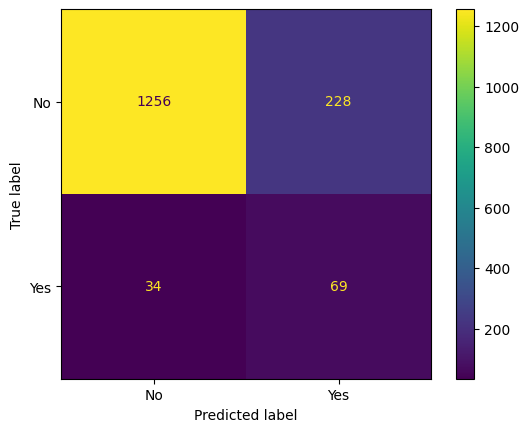

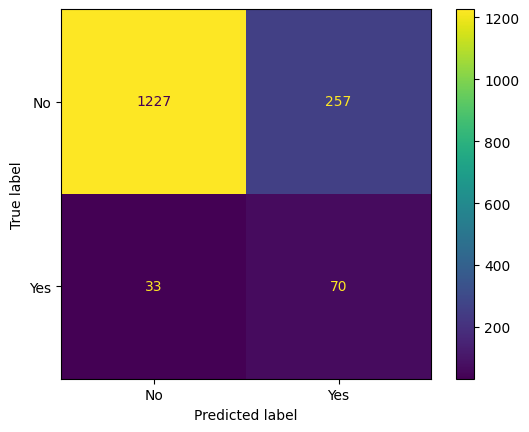

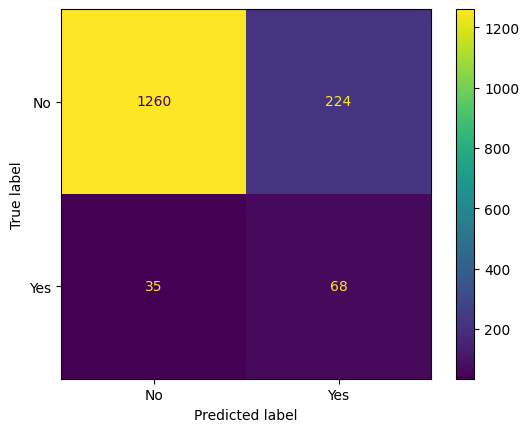

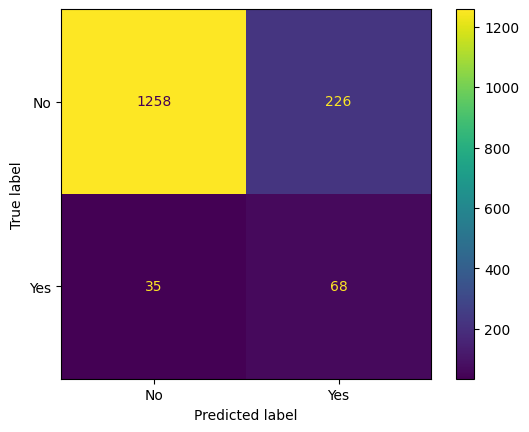

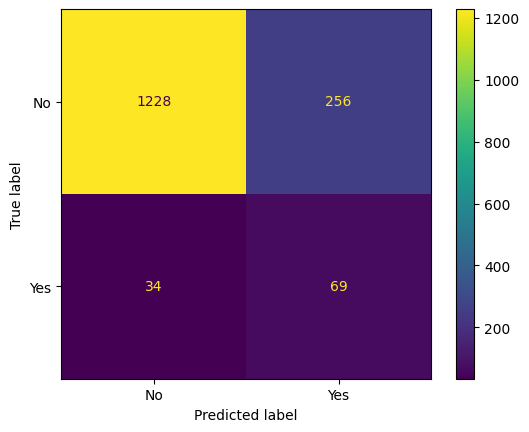

In [20]:
logistic_normal = logistic(X_train_normal, y_train_normal)
logistic_adasyn = logistic(X_train_adasyn, y_train_adasyn)
logistic_smote = logistic(X_train_smote, y_train_smote)
logistic_smotetomek = logistic(X_train_smotetomek, y_train_smotetomek)
logistic_undersampling = logistic(X_train_undersampling, y_train_undersampling)

normal_logistic = logistic_eval(logistic_normal, X_train_normal, y_train_normal, X_test, y_test)
adasyn_logistic = logistic_eval(logistic_adasyn, X_train_adasyn, y_train_adasyn, X_test, y_test)
smote_logistic = logistic_eval(logistic_smote, X_train_smote, y_train_smote, X_test, y_test)
smotetomek_logistic = logistic_eval(logistic_smotetomek, X_train_smotetomek, y_train_smotetomek, X_test, y_test)
undersampling_logistic = logistic_eval(logistic_undersampling, X_train_undersampling, y_train_undersampling, X_test, y_test)

(normal_logistic_report, normal_logistic_accuracy, normal_logistic_precision, normal_logistic_recall, normal_logistic_f1, normal_logistic_roc_auc, normal_logistic_pr_auc, normal_logistic_acc_training) = normal_logistic

(adasyn_logistic_report, adasyn_logistic_accuracy, adasyn_logistic_precision, adasyn_logistic_recall, adasyn_logistic_f1, adasyn_logistic_roc_auc, adasyn_logistic_pr_auc, adasyn_logistic_acc_training) = adasyn_logistic

(smote_logistic_report, smote_logistic_accuracy, smote_logistic_precision, smote_logistic_recall, smote_logistic_f1, smote_logistic_roc_auc, smote_logistic_pr_auc, smote_logistic_acc_training) = smote_logistic   

(smotetomek_logistic_report, smotetomek_logistic_accuracy, smotetomek_logistic_precision, smotetomek_logistic_recall, smotetomek_logistic_f1, smotetomek_logistic_roc_auc, smotetomek_logistic_pr_auc, smotetomek_logistic_acc_training) = smotetomek_logistic

(undersampling_logistic_report, undersampling_logistic_accuracy, undersampling_logistic_precision, undersampling_logistic_recall, undersampling_logistic_f1, undersampling_logistic_roc_auc, undersampling_logistic_pr_auc, undersampling_logistic_acc_training) = undersampling_logistic

### SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


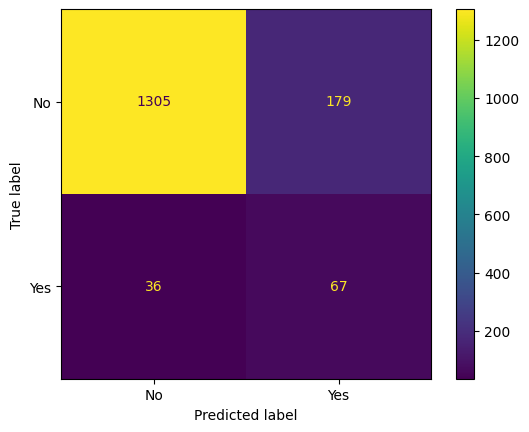

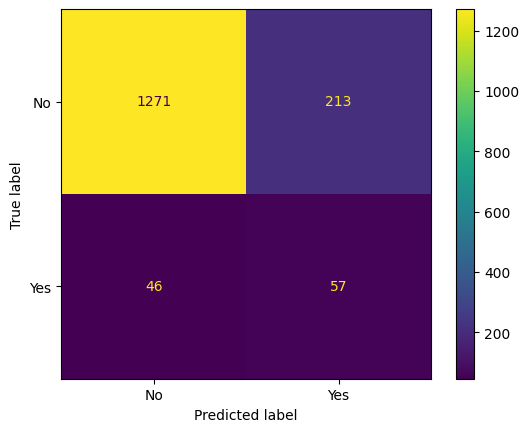

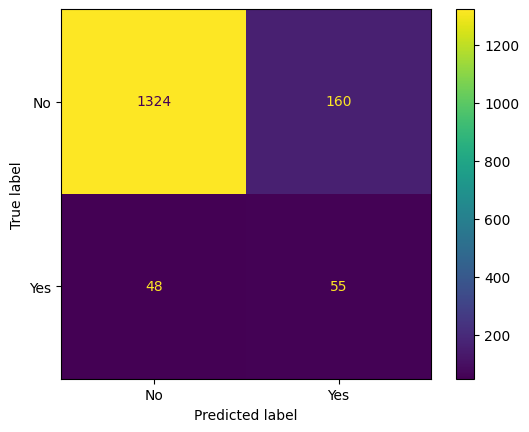

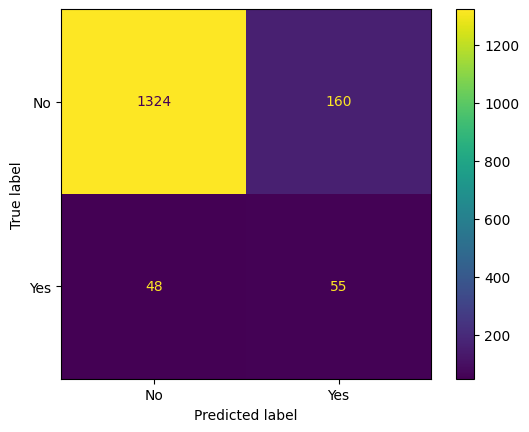

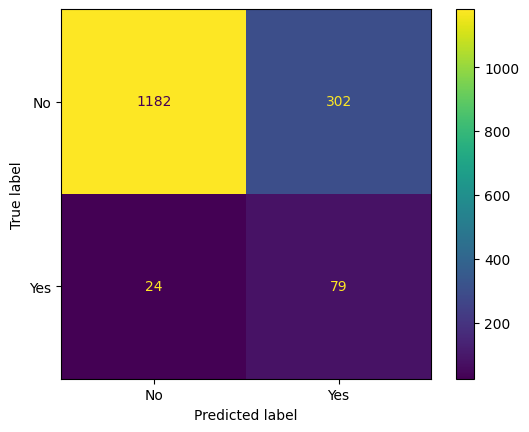

In [21]:
svm_normal = svm(X_train_normal, y_train_normal)
svm_adasyn = svm(X_train_adasyn, y_train_adasyn)
svm_smote = svm(X_train_smote, y_train_smote)
svm_smotetomek = svm(X_train_smotetomek, y_train_smotetomek)
svm_undersampling = svm(X_train_undersampling, y_train_undersampling)

normal_svm = svm_eval(svm_normal, X_train_normal, y_train_normal, X_test, y_test)
adasyn_svm = svm_eval(svm_adasyn, X_train_adasyn, y_train_adasyn, X_test, y_test)
smote_svm = svm_eval(svm_smote, X_train_smote, y_train_smote, X_test, y_test)
smotetomek_svm = svm_eval(svm_smotetomek, X_train_smotetomek, y_train_smotetomek, X_test, y_test)
undersampling_svm = svm_eval(svm_undersampling, X_train_undersampling, y_train_undersampling, X_test, y_test)

(normal_svm_report, normal_svm_accuracy, normal_svm_precision, normal_svm_recall, normal_svm_f1, normal_svm_roc_auc, normal_svm_pr_auc, normal_svm_acc_training) = normal_svm

(adasyn_svm_report, adasyn_svm_accuracy, adasyn_svm_precision, adasyn_svm_recall, adasyn_svm_f1, adasyn_svm_roc_auc, adasyn_svm_pr_auc, adasyn_svm_acc_training) = adasyn_svm

(smote_svm_report, smote_svm_accuracy, smote_svm_precision, smote_svm_recall, smote_svm_f1, smote_svm_roc_auc, smote_svm_pr_auc, smote_svm_acc_training) = smote_svm

(smotetomek_svm_report, smotetomek_svm_accuracy, smotetomek_svm_precision, smotetomek_svm_recall, smotetomek_svm_f1, smotetomek_svm_roc_auc, smotetomek_svm_pr_auc, smotetomek_svm_acc_training) = smotetomek_svm    

(undersampling_svm_report, undersampling_svm_accuracy, undersampling_svm_precision, undersampling_svm_recall, undersampling_svm_f1, undersampling_svm_roc_auc, undersampling_svm_pr_auc, undersampling_svm_acc_training) = undersampling_svm

### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


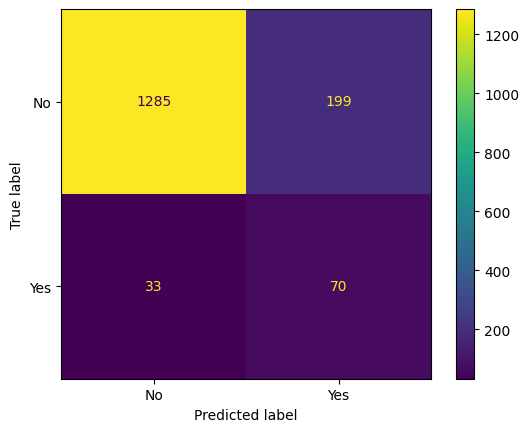

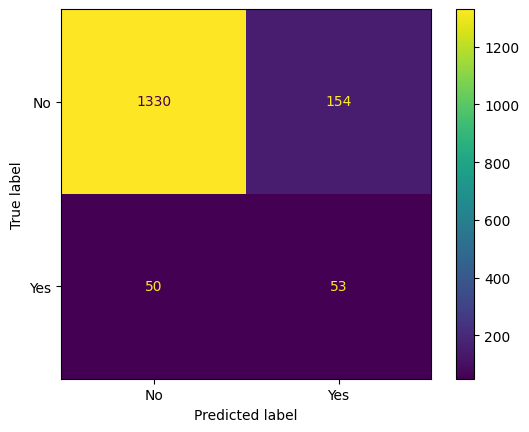

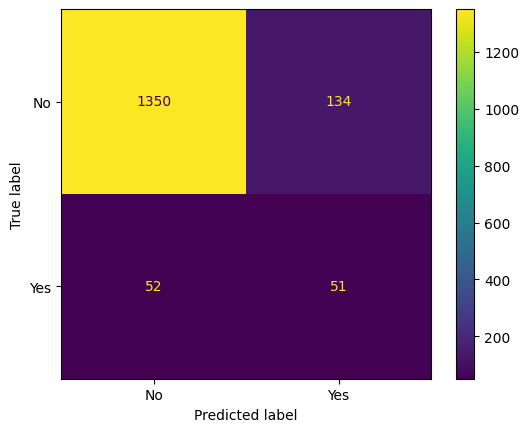

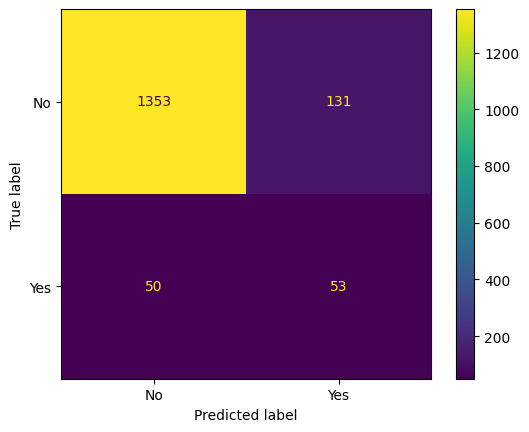

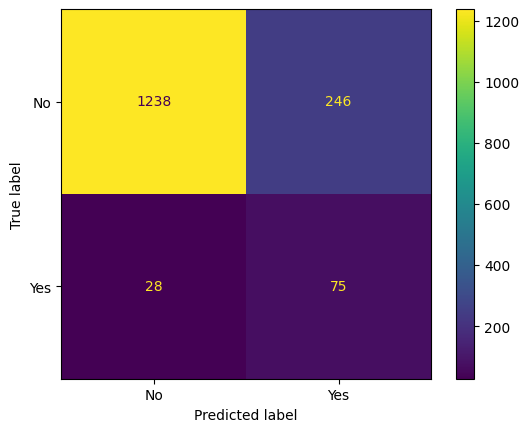

In [22]:
rf_normal = random_forest(X_train_normal, y_train_normal)
rf_adasyn = random_forest(X_train_adasyn, y_train_adasyn)
rf_smote = random_forest(X_train_smote, y_train_smote)
rf_smotetomek = random_forest(X_train_smotetomek, y_train_smotetomek)
rf_undersampling = random_forest(X_train_undersampling, y_train_undersampling)

normal_rf = rf_eval(rf_normal, X_train_normal, y_train_normal, X_test, y_test)
adasyn_rf = rf_eval(rf_adasyn, X_train_adasyn, y_train_adasyn, X_test, y_test)
smote_rf = rf_eval(rf_smote, X_train_smote, y_train_smote, X_test, y_test)
smotetomek_rf = rf_eval(rf_smotetomek, X_train_smotetomek, y_train_smotetomek, X_test, y_test)
undersampling_rf = rf_eval(rf_undersampling, X_train_undersampling, y_train_undersampling, X_test, y_test)

(normal_rf_report, normal_rf_accuracy, normal_rf_precision, normal_rf_recall, normal_rf_f1, normal_rf_roc_auc, normal_rf_pr_auc, normal_rf_acc_training) = normal_rf

(adasyn_rf_report, adasyn_rf_accuracy, adasyn_rf_precision, adasyn_rf_recall, adasyn_rf_f1, adasyn_rf_roc_auc, adasyn_rf_pr_auc, adasyn_rf_acc_training) = adasyn_rf

(smote_rf_report, smote_rf_accuracy, smote_rf_precision, smote_rf_recall, smote_rf_f1, smote_rf_roc_auc, smote_rf_pr_auc, smote_rf_acc_training) = smote_rf

(smotetomek_rf_report, smotetomek_rf_accuracy, smotetomek_rf_precision, smotetomek_rf_recall, smotetomek_rf_f1, smotetomek_rf_roc_auc, smotetomek_rf_pr_auc, smotetomek_rf_acc_training) = smotetomek_rf

(undersampling_rf_report, undersampling_rf_accuracy, undersampling_rf_precision, undersampling_rf_recall, undersampling_rf_f1, undersampling_rf_roc_auc, undersampling_rf_pr_auc, undersampling_rf_acc_training) = undersampling_rf

## Cost-Sensitive Boosting Models

### XGBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


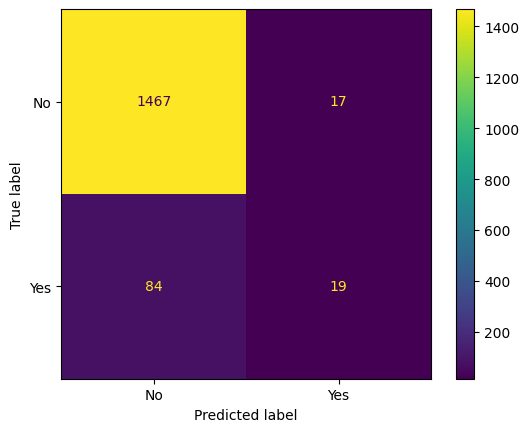

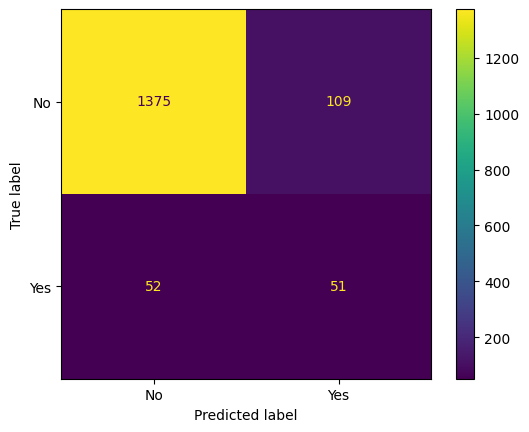

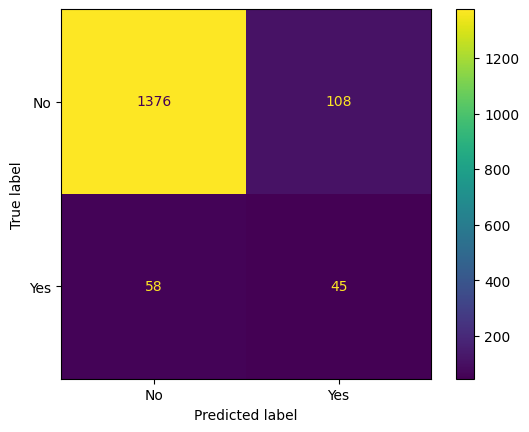

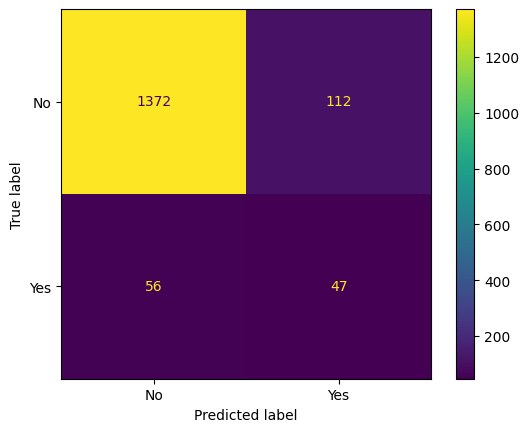

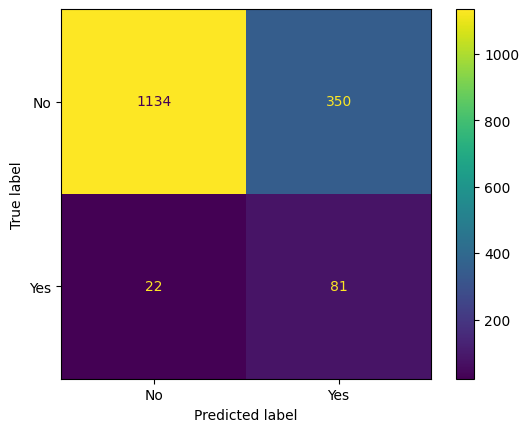

In [23]:
xgb_normal = xgboost(X_train_normal, y_train_normal)
xgb_adasyn = balanced_xgboost(X_train_adasyn, y_train_adasyn)
xgb_smote = balanced_xgboost(X_train_smote, y_train_smote)
xgb_smotetomek = balanced_xgboost(X_train_smotetomek, y_train_smotetomek)
xgb_undersampling = balanced_xgboost(X_train_undersampling, y_train_undersampling)

normal_xgb = xgb_eval(xgb_normal, X_train_normal, y_train_normal, X_test, y_test)
adasyn_xgb = xgb_eval(xgb_adasyn, X_train_adasyn, y_train_adasyn, X_test, y_test)
smote_xgb = xgb_eval(xgb_smote, X_train_smote, y_train_smote, X_test, y_test)
smotetomek_xgb = xgb_eval(xgb_smotetomek, X_train_smotetomek, y_train_smotetomek, X_test, y_test)
undersampling_xgb = xgb_eval(xgb_undersampling, X_train_undersampling, y_train_undersampling, X_test, y_test)

(normal_xgb_report, normal_xgb_accuracy, normal_xgb_precision, normal_xgb_recall, normal_xgb_f1, normal_xgb_roc_auc, normal_xgb_pr_auc, normal_xgb_acc_training) = normal_xgb

(adasyn_xgb_report, adasyn_xgb_accuracy, adasyn_xgb_precision, adasyn_xgb_recall, adasyn_xgb_f1, adasyn_xgb_roc_auc, adasyn_xgb_pr_auc, adasyn_xgb_acc_training) = adasyn_xgb

(smote_xgb_report, smote_xgb_accuracy, smote_xgb_precision, smote_xgb_recall, smote_xgb_f1, smote_xgb_roc_auc, smote_xgb_pr_auc, smote_xgb_acc_training) = smote_xgb

(smotetomek_xgb_report, smotetomek_xgb_accuracy, smotetomek_xgb_precision, smotetomek_xgb_recall, smotetomek_xgb_f1, smotetomek_xgb_roc_auc, smotetomek_xgb_pr_auc, smotetomek_xgb_acc_training) = smotetomek_xgb

(undersampling_xgb_report, undersampling_xgb_accuracy, undersampling_xgb_precision, undersampling_xgb_recall, undersampling_xgb_f1, undersampling_xgb_roc_auc, undersampling_xgb_pr_auc, undersampling_xgb_acc_training) = undersampling_xgb

### CatBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.6870963	total: 142ms	remaining: 28.3s
1:	learn: 0.6816386	total: 149ms	remaining: 14.7s
2:	learn: 0.6757910	total: 155ms	remaining: 10.2s
3:	learn: 0.6705279	total: 161ms	remaining: 7.88s
4:	learn: 0.6676869	total: 165ms	remaining: 6.43s
5:	learn: 0.6624586	total: 170ms	remaining: 5.49s
6:	learn: 0.6569072	total: 177ms	remaining: 4.87s
7:	learn: 0.6526034	total: 182ms	remaining: 4.37s
8:	learn: 0.6471107	total: 188ms	remaining: 3.98s
9:	learn: 0.6418112	total: 193ms	remaining: 3.67s
10:	learn: 0.6371934	total: 198ms	remaining: 3.41s
11:	learn: 0.6346098	total: 201ms	remaining: 3.16s
12:	learn: 0.6295484	total: 206ms	remaining: 2.96s
13:	learn: 0.6257514	total: 209ms	remaining: 2.77s
14:	learn: 0.6209787	total: 213ms	remaining: 2.62s
15:	learn: 0.6170592	total: 217ms	remaining: 2.49s
16:	learn: 0.6126518	total: 220ms	remaining: 2.37s
17:	learn: 0.6086329	total: 223ms	remaining: 2.26s
18:	learn: 0.6047445	total: 22

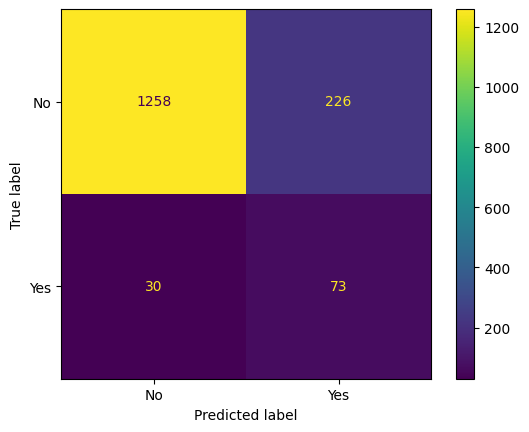

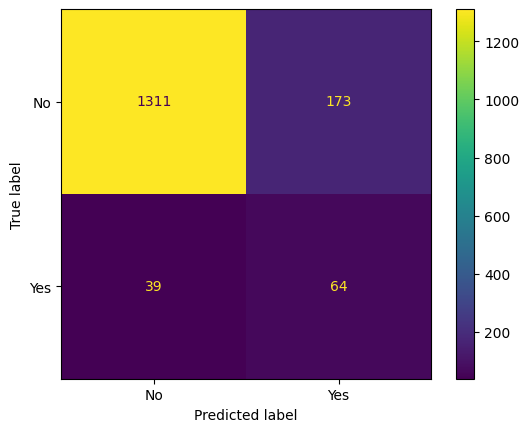

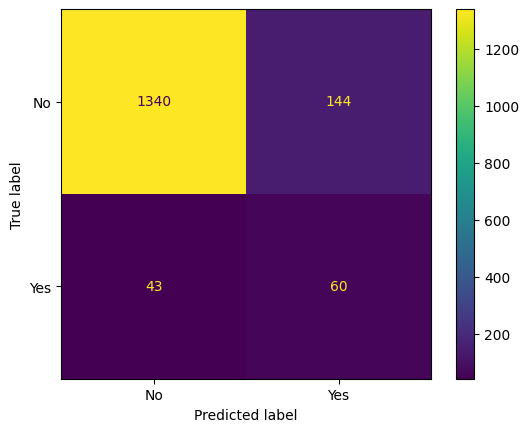

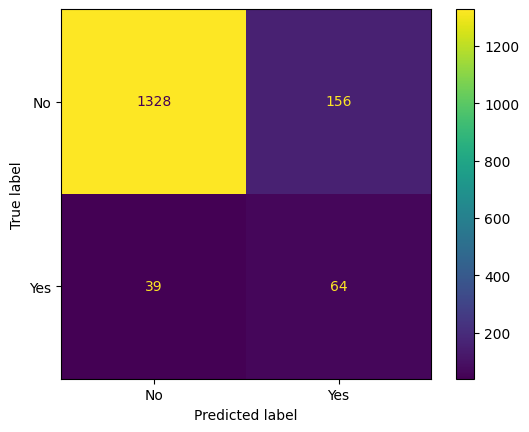

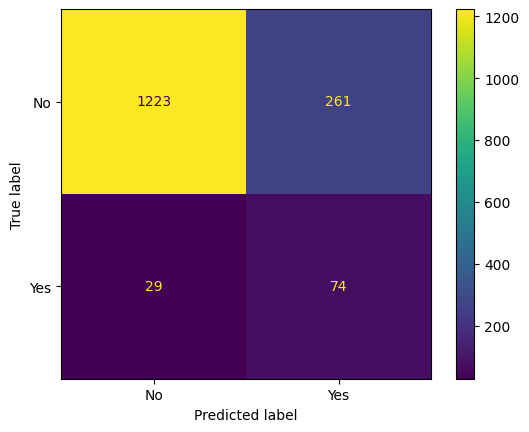

In [24]:
cb_normal = catboost(X_train_normal, y_train_normal)
cb_adasyn = balanced_catboost(X_train_adasyn, y_train_adasyn)
cb_smote = balanced_catboost(X_train_smote, y_train_smote)
cb_smotetomek = balanced_catboost(X_train_smotetomek, y_train_smotetomek)
cb_undersampling = balanced_catboost(X_train_undersampling, y_train_undersampling)

normal_cb = cb_eval(cb_normal, X_train_normal, y_train_normal, X_test, y_test)
adasyn_cb = cb_eval(cb_adasyn, X_train_adasyn, y_train_adasyn, X_test, y_test)
smote_cb = cb_eval(cb_smote, X_train_smote, y_train_smote, X_test, y_test)
smotetomek_cb = cb_eval(cb_smotetomek, X_train_smotetomek, y_train_smotetomek, X_test, y_test)
undersampling_cb = cb_eval(cb_undersampling, X_train_undersampling, y_train_undersampling, X_test, y_test)

(normal_cb_report, normal_cb_accuracy, normal_cb_precision, normal_cb_recall, normal_cb_f1, normal_cb_roc_auc, normal_cb_pr_auc, normal_cb_acc_training) = normal_cb

(adasyn_cb_report, adasyn_cb_accuracy, adasyn_cb_precision, adasyn_cb_recall, adasyn_cb_f1, adasyn_cb_roc_auc, adasyn_cb_pr_auc, adasyn_cb_acc_training) = adasyn_cb

(smote_cb_report, smote_cb_accuracy, smote_cb_precision, smote_cb_recall, smote_cb_f1, smote_cb_roc_auc, smote_cb_pr_auc, smote_cb_acc_training) = smote_cb

(smotetomek_cb_report, smotetomek_cb_accuracy, smotetomek_cb_precision, smotetomek_cb_recall, smotetomek_cb_f1, smotetomek_cb_roc_auc, smotetomek_cb_pr_auc, smotetomek_cb_acc_training) = smotetomek_cb

(undersampling_cb_report, undersampling_cb_accuracy, undersampling_cb_precision, undersampling_cb_recall, undersampling_cb_f1, undersampling_cb_roc_auc, undersampling_cb_pr_auc, undersampling_cb_acc_training) = undersampling_cb

## Visualization

C:\Users\asus\AppData\Local\Temp\ipykernel_27960\3526288819.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=p_df, x="Precision", y="Model", hue="Sampling", ci=None, palette="viridis")


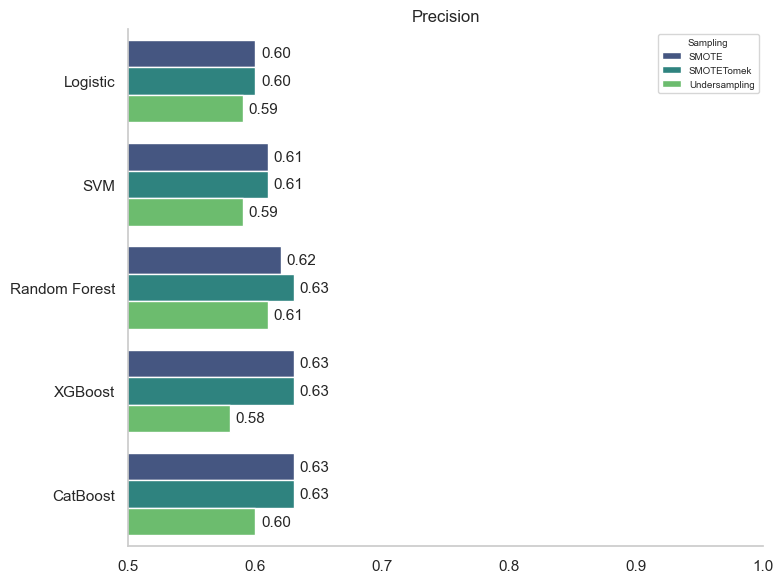

In [25]:
p = [
    {"Model": "Logistic", "Sampling": "SMOTE", "Precision": float(smote_logistic_precision)},
    {"Model": "Logistic", "Sampling": "SMOTETomek", "Precision": float(smotetomek_logistic_precision)},
    {"Model": "Logistic", "Sampling": "Undersampling", "Precision": float(undersampling_logistic_precision)},

    {"Model": "SVM", "Sampling": "SMOTE", "Precision": float(smote_svm_precision)},
    {"Model": "SVM", "Sampling": "SMOTETomek", "Precision": float(smotetomek_svm_precision)},
    {"Model": "SVM", "Sampling": "Undersampling", "Precision": float(undersampling_svm_precision)},

    {"Model": "Random Forest", "Sampling": "SMOTE", "Precision": float(smote_rf_precision)},
    {"Model": "Random Forest", "Sampling": "SMOTETomek", "Precision": float(smotetomek_rf_precision)},
    {"Model": "Random Forest", "Sampling": "Undersampling", "Precision": float(undersampling_rf_precision)},
    
    {"Model": "XGBoost", "Sampling": "SMOTE", "Precision": float(smote_xgb_precision)},
    {"Model": "XGBoost", "Sampling": "SMOTETomek", "Precision": float(smotetomek_xgb_precision)},
    {"Model": "XGBoost", "Sampling": "Undersampling", "Precision": float(undersampling_xgb_precision)},

    {"Model": "CatBoost", "Sampling": "SMOTE", "Precision": float(smote_cb_precision)},
    {"Model": "CatBoost", "Sampling": "SMOTETomek", "Precision": float(smotetomek_cb_precision)},
    {"Model": "CatBoost", "Sampling": "Undersampling", "Precision": float(undersampling_cb_precision)},
]

p_df = pd.DataFrame.from_records(p)

model_order = ["Logistic", "SVM", "Random Forest", "XGBoost", "CatBoost"]
p_df["Model"] = pd.Categorical(p_df["Model"], categories=model_order, ordered=True)

sampling_order = ["SMOTE", "SMOTETomek", "Undersampling"]
p_df["Sampling"] = pd.Categorical(p_df["Sampling"], categories=sampling_order, ordered=True)

p_df = p_df.sort_values(["Model", "Sampling"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=p_df, x="Precision", y="Model", hue="Sampling", ci=None, palette="viridis")
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(0.5, 1.0)
plt.title("Precision")
plt.legend(title="Sampling", loc="upper right", fontsize=7, title_fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.annotate(f"{width:.2f}", (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=11, xytext=(4, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_27960\4167062797.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=r_df, x="Recall", y="Model", hue="Sampling", ci=None, palette="viridis")


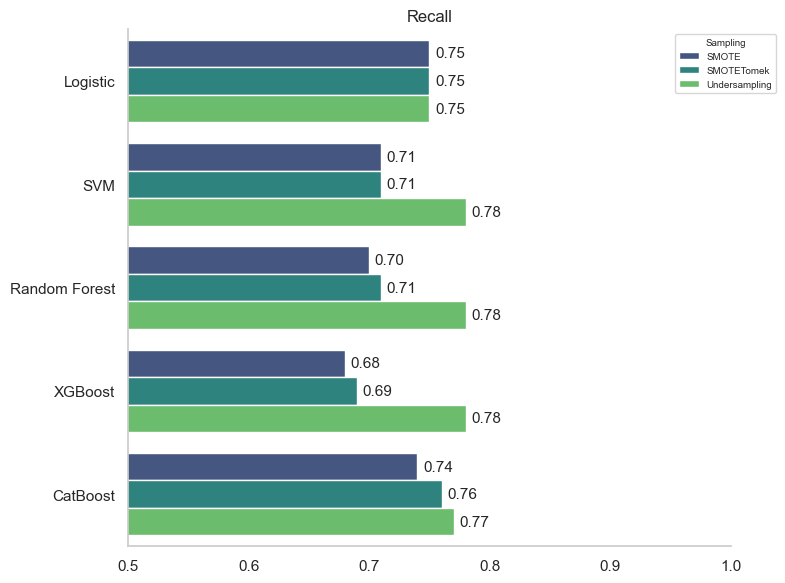

In [26]:
r = [
    {"Model": "Logistic", "Sampling": "SMOTE", "Recall": float(smote_logistic_recall)},
    {"Model": "Logistic", "Sampling": "SMOTETomek", "Recall": float(smotetomek_logistic_recall)},
    {"Model": "Logistic", "Sampling": "Undersampling", "Recall": float(undersampling_logistic_recall)},

    {"Model": "SVM", "Sampling": "SMOTE", "Recall": float(smote_svm_recall)},
    {"Model": "SVM", "Sampling": "SMOTETomek", "Recall": float(smotetomek_svm_recall)},
    {"Model": "SVM", "Sampling": "Undersampling", "Recall": float(undersampling_svm_recall)},

    {"Model": "Random Forest", "Sampling": "SMOTE", "Recall": float(smote_rf_recall)},
    {"Model": "Random Forest", "Sampling": "SMOTETomek", "Recall": float(smotetomek_rf_recall)},
    {"Model": "Random Forest", "Sampling": "Undersampling", "Recall": float(undersampling_rf_recall)},
    
    {"Model": "XGBoost", "Sampling": "SMOTE", "Recall": float(smote_xgb_recall)},
    {"Model": "XGBoost", "Sampling": "SMOTETomek", "Recall": float(smotetomek_xgb_recall)},
    {"Model": "XGBoost", "Sampling": "Undersampling", "Recall": float(undersampling_xgb_recall)},

    {"Model": "CatBoost", "Sampling": "SMOTE", "Recall": float(smote_cb_recall)},
    {"Model": "CatBoost", "Sampling": "SMOTETomek", "Recall": float(smotetomek_cb_recall)},
    {"Model": "CatBoost", "Sampling": "Undersampling", "Recall": float(undersampling_cb_recall)},
]

r_df = pd.DataFrame.from_records(r)

model_order = ["Logistic", "SVM", "Random Forest", "XGBoost", "CatBoost"]
r_df["Model"] = pd.Categorical(r_df["Model"], categories=model_order, ordered=True)

sampling_order = ["SMOTE", "SMOTETomek", "Undersampling"]
r_df["Sampling"] = pd.Categorical(r_df["Sampling"], categories=sampling_order, ordered=True)

r_df = r_df.sort_values(["Model", "Sampling"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=r_df, x="Recall", y="Model", hue="Sampling", ci=None, palette="viridis")
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(0.5, 1.0)
plt.title("Recall")
plt.legend(title="Sampling", bbox_to_anchor=(0.9, 1), loc="upper left", fontsize=7, title_fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.annotate(f"{width:.2f}", (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=11, xytext=(4, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_27960\1133725128.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=f1_df, x="F1-Score", y="Model", hue="Sampling", ci=None, palette="viridis")


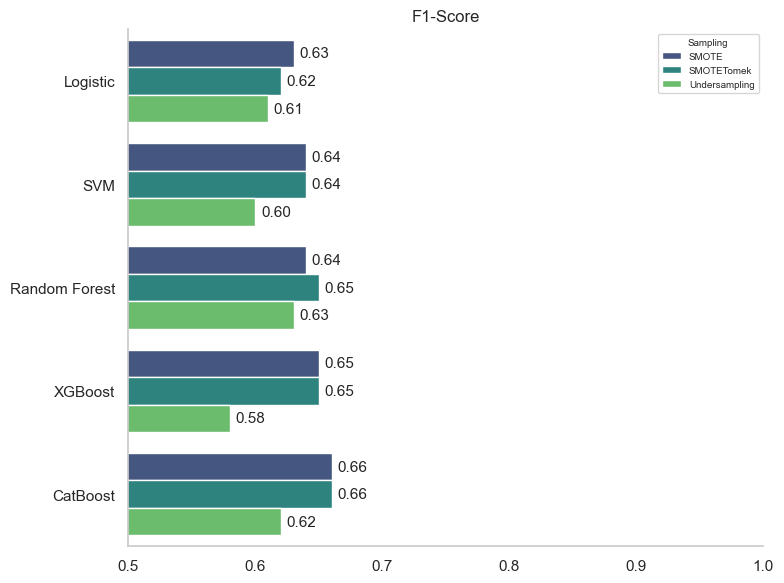

In [27]:
f1 = [
    {"Model": "Logistic", "Sampling": "SMOTE", "F1-Score": float(smote_logistic_f1)},
    {"Model": "Logistic", "Sampling": "SMOTETomek", "F1-Score": float(smotetomek_logistic_f1)},
    {"Model": "Logistic", "Sampling": "Undersampling", "F1-Score": float(undersampling_logistic_f1)},
    
    {"Model": "SVM", "Sampling": "SMOTE", "F1-Score": float(smote_svm_f1)},
    {"Model": "SVM", "Sampling": "SMOTETomek", "F1-Score": float(smotetomek_svm_f1)},
    {"Model": "SVM", "Sampling": "Undersampling", "F1-Score": float(undersampling_svm_f1)},

    {"Model": "Random Forest", "Sampling": "SMOTE", "F1-Score": float(smote_rf_f1)},
    {"Model": "Random Forest", "Sampling": "SMOTETomek", "F1-Score": float(smotetomek_rf_f1)},
    {"Model": "Random Forest", "Sampling": "Undersampling", "F1-Score": float(undersampling_rf_f1)},
    
    {"Model": "XGBoost", "Sampling": "SMOTE", "F1-Score": float(smote_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "SMOTETomek", "F1-Score": float(smotetomek_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "Undersampling", "F1-Score": float(undersampling_xgb_f1)},

    {"Model": "CatBoost", "Sampling": "SMOTE", "F1-Score": float(smote_cb_f1)},
    {"Model": "CatBoost", "Sampling": "SMOTETomek", "F1-Score": float(smotetomek_cb_f1)},
    {"Model": "CatBoost", "Sampling": "Undersampling", "F1-Score": float(undersampling_cb_f1)},
]

f1_df = pd.DataFrame.from_records(f1)

model_order = ["Logistic", "SVM", "Random Forest", "XGBoost", "CatBoost"]
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

sampling_order = ["SMOTE", "SMOTETomek", "Undersampling"]
f1_df["Sampling"] = pd.Categorical(f1_df["Sampling"], categories=sampling_order, ordered=True)

f1_df = f1_df.sort_values(["Model", "Sampling"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=f1_df, x="F1-Score", y="Model", hue="Sampling", ci=None, palette="viridis")
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(0.5, 1.0)
plt.title("F1-Score")
plt.legend(title="Sampling", loc="upper right", fontsize=7, title_fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.annotate(f"{width:.2f}", (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=11, xytext=(4, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

## Model Comparison

In [28]:
rows = [
    ("Logistic", "Normal", normal_logistic_accuracy, normal_logistic_precision, normal_logistic_recall, normal_logistic_f1, normal_logistic_roc_auc, normal_logistic_pr_auc, normal_logistic_acc_training),
    ("Logistic", "ADASYN", adasyn_logistic_accuracy, adasyn_logistic_precision, adasyn_logistic_recall, adasyn_logistic_f1, adasyn_logistic_roc_auc, adasyn_logistic_pr_auc, adasyn_logistic_acc_training),
    ("Logistic", "SMOTE", smote_logistic_accuracy, smote_logistic_precision, smote_logistic_recall, smote_logistic_f1, smote_logistic_roc_auc, smote_logistic_pr_auc, smote_logistic_acc_training),
    ("Logistic", "SMOTETomek", smotetomek_logistic_accuracy, smotetomek_logistic_precision, smotetomek_logistic_recall, smotetomek_logistic_f1, smotetomek_logistic_roc_auc, smotetomek_logistic_pr_auc, smotetomek_logistic_acc_training),
    ("Logistic", "Undersampling", undersampling_logistic_accuracy, undersampling_logistic_precision, undersampling_logistic_recall, undersampling_logistic_f1, undersampling_logistic_roc_auc, undersampling_logistic_pr_auc, undersampling_logistic_acc_training),

    ("SVM", "Normal", normal_svm_accuracy, normal_svm_precision, normal_svm_recall, normal_svm_f1, normal_svm_roc_auc, normal_svm_pr_auc, normal_svm_acc_training),
    ("SVM", "ADASYN", adasyn_svm_accuracy, adasyn_svm_precision, adasyn_svm_recall, adasyn_svm_f1, adasyn_svm_roc_auc, adasyn_svm_pr_auc, adasyn_svm_acc_training),
    ("SVM", "SMOTE", smote_svm_accuracy, smote_svm_precision, smote_svm_recall, smote_svm_f1, smote_svm_roc_auc, smote_svm_pr_auc, smote_svm_acc_training),
    ("SVM", "SMOTETomek", smotetomek_svm_accuracy, smotetomek_svm_precision, smotetomek_svm_recall, smotetomek_svm_f1, smotetomek_svm_roc_auc, smotetomek_svm_pr_auc, smotetomek_svm_acc_training),
    ("SVM", "Undersampling", undersampling_svm_accuracy, undersampling_svm_precision, undersampling_svm_recall, undersampling_svm_f1, undersampling_svm_roc_auc, undersampling_svm_pr_auc, undersampling_svm_acc_training),

    ("Random Forest", "Normal", normal_rf_accuracy, normal_rf_precision, normal_rf_recall, normal_rf_f1, normal_rf_roc_auc, normal_rf_pr_auc, normal_rf_acc_training),
    ("Random Forest", "ADASYN", adasyn_rf_accuracy, adasyn_rf_precision, adasyn_rf_recall, adasyn_rf_f1, adasyn_rf_roc_auc, adasyn_rf_pr_auc, adasyn_rf_acc_training),
    ("Random Forest", "SMOTE", smote_rf_accuracy, smote_rf_precision, smote_rf_recall, smote_rf_f1, smote_rf_roc_auc, smote_rf_pr_auc, smote_rf_acc_training),
    ("Random Forest", "SMOTETomek", smotetomek_rf_accuracy, smotetomek_rf_precision, smotetomek_rf_recall, smotetomek_rf_f1, smotetomek_rf_roc_auc, smotetomek_rf_pr_auc, smotetomek_rf_acc_training),
    ("Random Forest", "Undersampling", undersampling_rf_accuracy, undersampling_rf_precision, undersampling_rf_recall, undersampling_rf_f1, undersampling_rf_roc_auc, undersampling_rf_pr_auc, undersampling_rf_acc_training),

    ("XGBoost", "Normal", normal_xgb_accuracy, normal_xgb_precision, normal_xgb_recall, normal_xgb_f1, normal_xgb_roc_auc, normal_xgb_pr_auc, normal_xgb_acc_training),
    ("XGBoost", "ADASYN", adasyn_xgb_accuracy, adasyn_xgb_precision, adasyn_xgb_recall, adasyn_xgb_f1, adasyn_xgb_roc_auc, adasyn_xgb_pr_auc, adasyn_xgb_acc_training),
    ("XGBoost", "SMOTE", smote_xgb_accuracy, smote_xgb_precision, smote_xgb_recall, smote_xgb_f1, smote_xgb_roc_auc, smote_xgb_pr_auc, smote_xgb_acc_training),
    ("XGBoost", "SMOTETomek", smotetomek_xgb_accuracy, smotetomek_xgb_precision, smotetomek_xgb_recall, smotetomek_xgb_f1, smotetomek_xgb_roc_auc, smotetomek_xgb_pr_auc, smotetomek_xgb_acc_training),
    ("XGBoost", "Undersampling", undersampling_xgb_accuracy, undersampling_xgb_precision, undersampling_xgb_recall, undersampling_xgb_f1, undersampling_xgb_roc_auc, undersampling_xgb_pr_auc, undersampling_xgb_acc_training),

    ("CatBoost", "Normal", normal_cb_accuracy, normal_cb_precision, normal_cb_recall, normal_cb_f1, normal_cb_roc_auc, normal_cb_pr_auc, normal_cb_acc_training),
    ("CatBoost", "ADASYN", adasyn_cb_accuracy, adasyn_cb_precision, adasyn_cb_recall, adasyn_cb_f1, adasyn_cb_roc_auc, adasyn_cb_pr_auc, adasyn_cb_acc_training),
    ("CatBoost", "SMOTE", smote_cb_accuracy, smote_cb_precision, smote_cb_recall, smote_cb_f1, smote_cb_roc_auc, smote_cb_pr_auc, smote_cb_acc_training),
    ("CatBoost", "SMOTETomek", smotetomek_cb_accuracy, smotetomek_cb_precision, smotetomek_cb_recall, smotetomek_cb_f1, smotetomek_cb_roc_auc, smotetomek_cb_pr_auc, smotetomek_cb_acc_training),
    ("CatBoost", "Undersampling", undersampling_cb_accuracy, undersampling_cb_precision, undersampling_cb_recall, undersampling_cb_f1, undersampling_cb_roc_auc, undersampling_cb_pr_auc, undersampling_cb_acc_training),
]
results = {}
for model_name, sampling, acc, prec, rec, f1, roc_auc, pr_auc, acc_training in rows:
    results.setdefault(sampling, {})[model_name] = {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        "acc_training": (acc_training)
    }
df_results = pd.DataFrame(rows, columns=["Model", "Sampling", "Accuracy", "Precision", "Recall", "F1-score", "ROC AUC", "PR AUC", "Acc Training"])

df_results["Model"] = pd.Categorical(df_results["Model"], categories=model_order, ordered=True)
sampling_order_full = ["Normal", "ADASYN", "SMOTE", "SMOTETomek", "Undersampling"]
df_results["Sampling"] = pd.Categorical(df_results["Sampling"], categories=sampling_order_full, ordered=True)

df_results = df_results.sort_values(["Sampling", "Model"]).reset_index(drop=True)

metric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC", "PR AUC", "Acc Training"]
df_results[metric_cols] = df_results[metric_cols]

df_results

,Model,Sampling,Accuracy,Precision,Recall,F1-score,ROC AUC,PR AUC,Acc Training
0,Logistic,Normal,0.834909,0.60,0.76,0.63,0.76,0.18,0.79 ± 0.04
1,SVM,Normal,0.864524,0.62,0.76,0.65,0.76,0.20,0.79 ± 0.03
2,Random Forest,Normal,0.853812,0.62,0.77,0.65,0.77,0.20,0.81 ± 0.05
3,XGBoost,Normal,0.936358,0.74,0.59,0.62,0.59,0.15,0.63 ± 0.01
4,CatBoost,Normal,0.838689,0.61,0.78,0.64,0.78,0.19,0.81 ± 0.04
5,Logistic,ADASYN,0.817265,0.59,0.75,0.61,0.75,0.17,0.77 ± 0.02
6,SVM,ADASYN,0.836799,0.59,0.70,0.61,0.70,0.15,0.88 ± 0.01
7,Random Forest,ADASYN,0.871456,0.61,0.71,0.64,0.71,0.16,0.92 ± 0.01
8,XGBoost,ADASYN,0.898551,0.64,0.71,0.67,0.71,0.19,0.93 ± 0.01
9,CatBoost,ADASYN,0.866415,0.62,0.75,0.65,0.75,0.19,0.90 ± 0.01


In [29]:
df["diabetic"].value_counts()

diabetic
No     4946
Yes     342
Name: count, dtype: int64

## Ratio Sampling

In [30]:
X_train_ratio_2, y_train_ratio_2 = ratio_sampling(df_train, 0.5)
X_train_ratio_3, y_train_ratio_3 = ratio_sampling(df_train, 0.33)
X_train_ratio_4, y_train_ratio_4 = ratio_sampling(df_train, 0.25)
X_train_ratio_5, y_train_ratio_5 = ratio_sampling(df_train, 0.2)
X_train_ratio_10, y_train_ratio_10 = ratio_sampling(df_train, 0.1)

In [31]:
y_train_ratio_2.value_counts()

diabetic
0    478
1    239
Name: count, dtype: int64

### Baseline Models

#### Logistic Regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


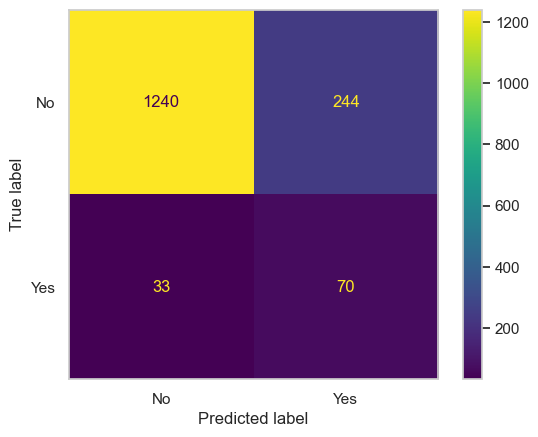

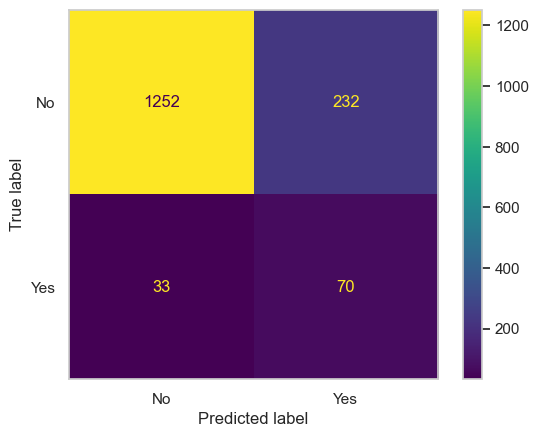

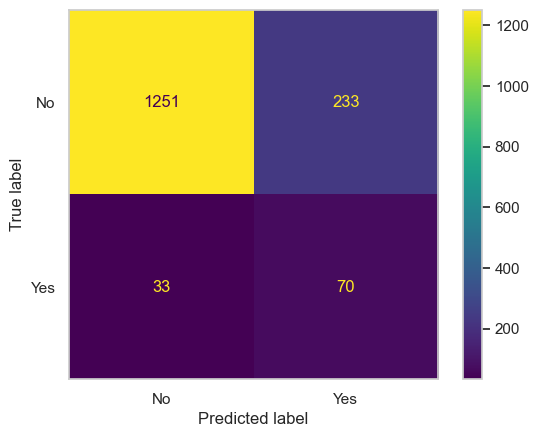

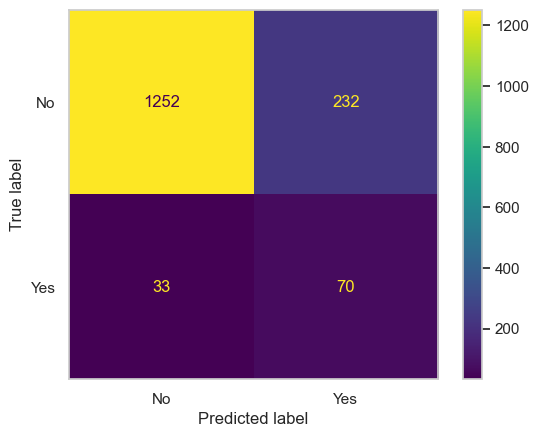

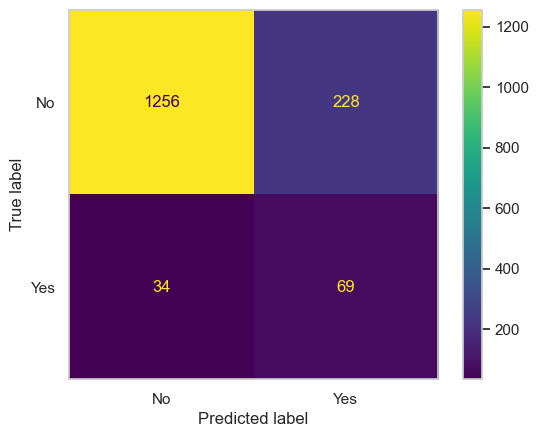

In [32]:
logistic_ratio_2 = logistic(X_train_ratio_2, y_train_ratio_2)
logistic_ratio_3 = logistic(X_train_ratio_3, y_train_ratio_3)
logistic_ratio_4 = logistic(X_train_ratio_4, y_train_ratio_4)
logistic_ratio_5 = logistic(X_train_ratio_5, y_train_ratio_5)
logistic_ratio_10 = logistic(X_train_ratio_10, y_train_ratio_10)

ratio_2_logistic = logistic_eval(logistic_ratio_2, X_train_ratio_2, y_train_ratio_2, X_test, y_test)
ratio_3_logistic = logistic_eval(logistic_ratio_3, X_train_ratio_3, y_train_ratio_3, X_test, y_test)
ratio_4_logistic = logistic_eval(logistic_ratio_4, X_train_ratio_4, y_train_ratio_4, X_test, y_test)
ratio_5_logistic = logistic_eval(logistic_ratio_5, X_train_ratio_5, y_train_ratio_5, X_test, y_test)
ratio_10_logistic = logistic_eval(logistic_ratio_10, X_train_ratio_10, y_train_ratio_10, X_test, y_test)

(ratio_2_logistic_report, ratio_2_logistic_accuracy, ratio_2_logistic_precision, ratio_2_logistic_recall, ratio_2_logistic_f1, ratio_2_logistic_roc_auc, ratio_2_logistic_pr_auc, ratio_2_logistic_acc_training) = ratio_2_logistic
(ratio_3_logistic_report, ratio_3_logistic_accuracy, ratio_3_logistic_precision, ratio_3_logistic_recall, ratio_3_logistic_f1, ratio_3_logistic_roc_auc, ratio_3_logistic_pr_auc, ratio_3_logistic_acc_training) = ratio_3_logistic
(ratio_4_logistic_report, ratio_4_logistic_accuracy, ratio_4_logistic_precision, ratio_4_logistic_recall, ratio_4_logistic_f1, ratio_4_logistic_roc_auc, ratio_4_logistic_pr_auc, ratio_4_logistic_acc_training) = ratio_4_logistic
(ratio_5_logistic_report, ratio_5_logistic_accuracy, ratio_5_logistic_precision, ratio_5_logistic_recall, ratio_5_logistic_f1, ratio_5_logistic_roc_auc, ratio_5_logistic_pr_auc, ratio_5_logistic_acc_training) = ratio_5_logistic
(ratio_10_logistic_report, ratio_10_logistic_accuracy, ratio_10_logistic_precision, ratio_10_logistic_recall, ratio_10_logistic_f1, ratio_10_logistic_roc_auc, ratio_10_logistic_pr_auc, ratio_10_logistic_acc_training) = ratio_10_logistic

#### SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


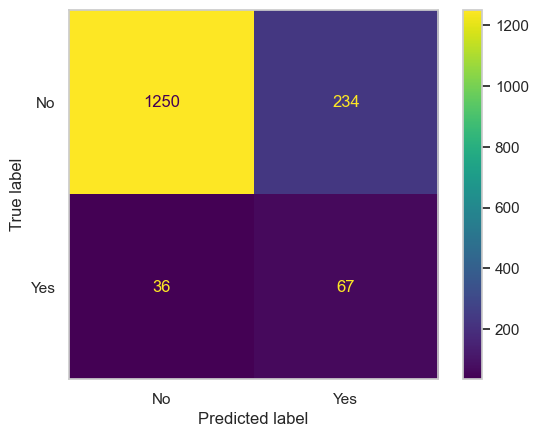

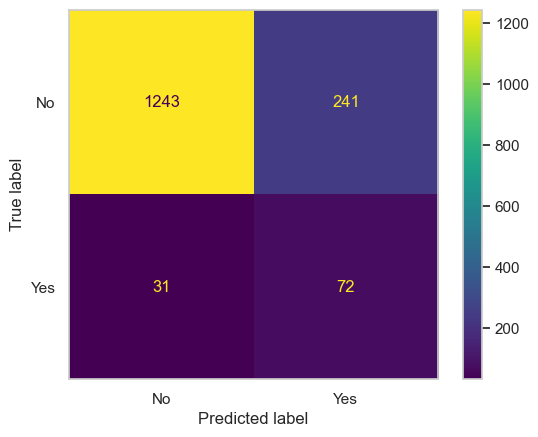

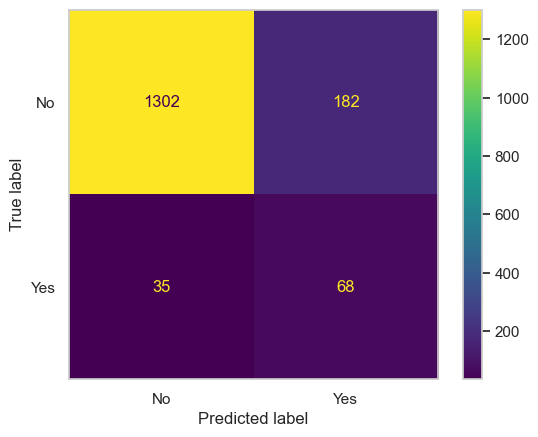

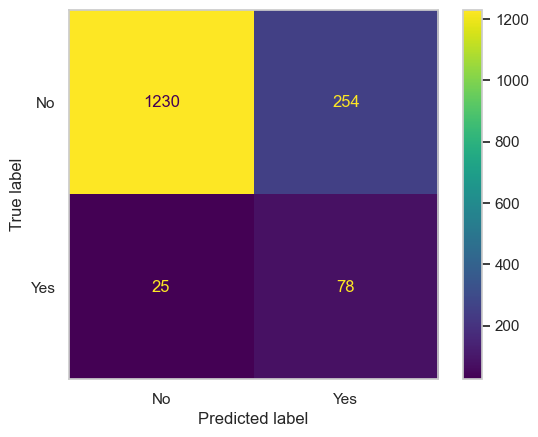

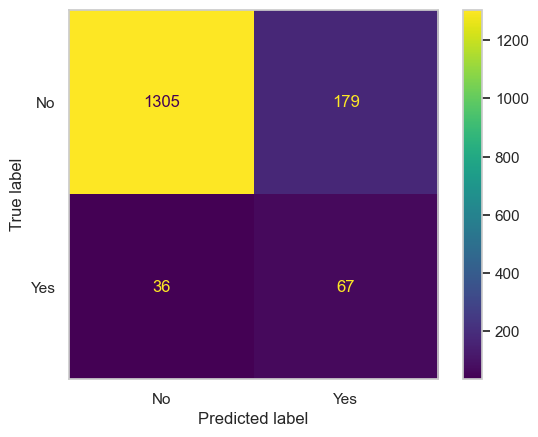

In [33]:
svm_ratio_2 = svm(X_train_ratio_2, y_train_ratio_2)
svm_ratio_3 = svm(X_train_ratio_3, y_train_ratio_3)
svm_ratio_4 = svm(X_train_ratio_4, y_train_ratio_4)
svm_ratio_5 = svm(X_train_ratio_5, y_train_ratio_5)
svm_ratio_10 = svm(X_train_ratio_10, y_train_ratio_10)

ratio_2_svm = svm_eval(svm_ratio_2, X_train_ratio_2, y_train_ratio_2, X_test, y_test)
ratio_3_svm = svm_eval(svm_ratio_3, X_train_ratio_3, y_train_ratio_3, X_test, y_test)
ratio_4_svm = svm_eval(svm_ratio_4, X_train_ratio_4, y_train_ratio_4, X_test, y_test)
ratio_5_svm = svm_eval(svm_ratio_5, X_train_ratio_5, y_train_ratio_5, X_test, y_test)
ratio_10_svm = svm_eval(svm_ratio_10, X_train_ratio_10, y_train_ratio_10, X_test, y_test)

(ratio_2_svm_report, ratio_2_svm_accuracy, ratio_2_svm_precision, ratio_2_svm_recall, ratio_2_svm_f1, ratio_2_svm_roc_auc, ratio_2_svm_pr_auc, ratio_2_svm_acc_training) = ratio_2_svm
(ratio_3_svm_report, ratio_3_svm_accuracy, ratio_3_svm_precision, ratio_3_svm_recall, ratio_3_svm_f1, ratio_3_svm_roc_auc, ratio_3_svm_pr_auc, ratio_3_svm_acc_training) = ratio_3_svm
(ratio_4_svm_report, ratio_4_svm_accuracy, ratio_4_svm_precision, ratio_4_svm_recall, ratio_4_svm_f1, ratio_4_svm_roc_auc, ratio_4_svm_pr_auc, ratio_4_svm_acc_training) = ratio_4_svm
(ratio_5_svm_report, ratio_5_svm_accuracy, ratio_5_svm_precision, ratio_5_svm_recall, ratio_5_svm_f1, ratio_5_svm_roc_auc, ratio_5_svm_pr_auc, ratio_5_svm_acc_training) = ratio_5_svm
(ratio_10_svm_report, ratio_10_svm_accuracy, ratio_10_svm_precision, ratio_10_svm_recall, ratio_10_svm_f1, ratio_10_svm_roc_auc, ratio_10_svm_pr_auc, ratio_10_svm_acc_training) = ratio_10_svm

#### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


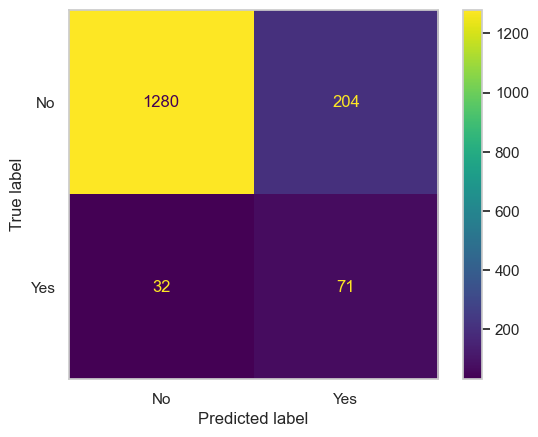

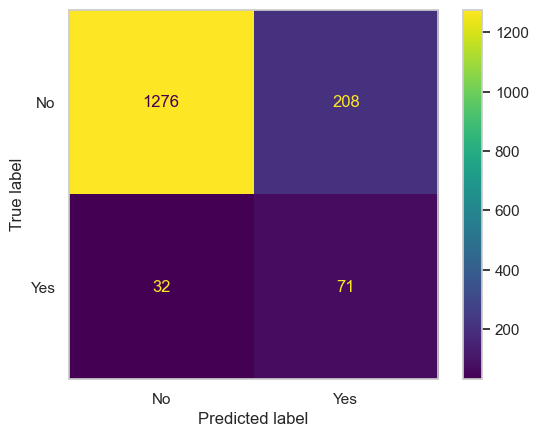

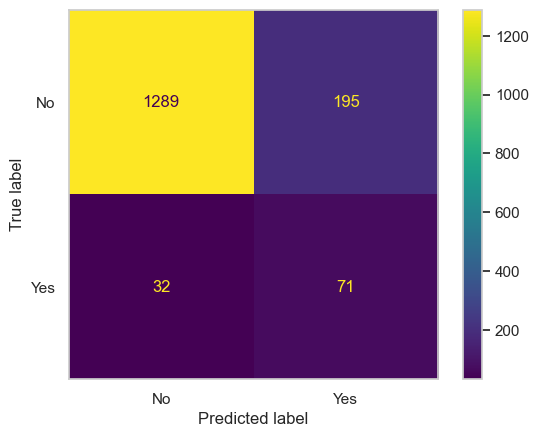

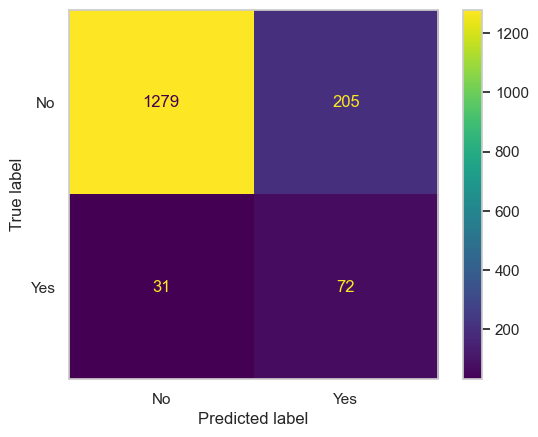

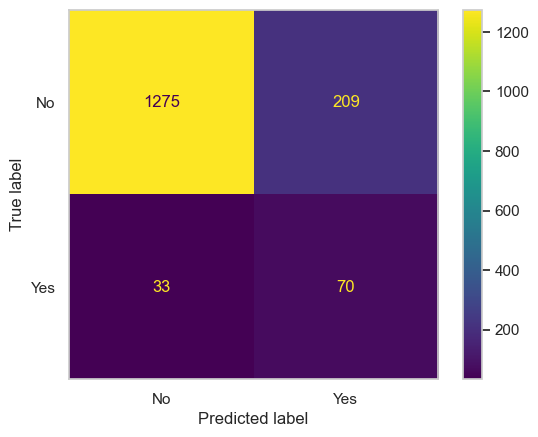

In [34]:
rf_ratio_2 = random_forest(X_train_ratio_2, y_train_ratio_2)
rf_ratio_3 = random_forest(X_train_ratio_3, y_train_ratio_3)
rf_ratio_4 = random_forest(X_train_ratio_4, y_train_ratio_4)
rf_ratio_5 = random_forest(X_train_ratio_5, y_train_ratio_5)
rf_ratio_10 = random_forest(X_train_ratio_10, y_train_ratio_10)

ratio_2_rf = rf_eval(rf_ratio_2, X_train_ratio_2, y_train_ratio_2, X_test, y_test)
ratio_3_rf = rf_eval(rf_ratio_3, X_train_ratio_3, y_train_ratio_3, X_test, y_test)
ratio_4_rf = rf_eval(rf_ratio_4, X_train_ratio_4, y_train_ratio_4, X_test, y_test)
ratio_5_rf = rf_eval(rf_ratio_5, X_train_ratio_5, y_train_ratio_5, X_test, y_test)
ratio_10_rf = rf_eval(rf_ratio_10, X_train_ratio_10, y_train_ratio_10, X_test, y_test)

(ratio_2_rf_report, ratio_2_rf_accuracy, ratio_2_rf_precision, ratio_2_rf_recall, ratio_2_rf_f1, ratio_2_rf_roc_auc, ratio_2_rf_pr_auc, ratio_2_rf_acc_training) = ratio_2_rf
(ratio_3_rf_report, ratio_3_rf_accuracy, ratio_3_rf_precision, ratio_3_rf_recall, ratio_3_rf_f1, ratio_3_rf_roc_auc, ratio_3_rf_pr_auc, ratio_3_rf_acc_training) = ratio_3_rf
(ratio_4_rf_report, ratio_4_rf_accuracy, ratio_4_rf_precision, ratio_4_rf_recall, ratio_4_rf_f1, ratio_4_rf_roc_auc, ratio_4_rf_pr_auc, ratio_4_rf_acc_training) = ratio_4_rf
(ratio_5_rf_report, ratio_5_rf_accuracy, ratio_5_rf_precision, ratio_5_rf_recall, ratio_5_rf_f1, ratio_5_rf_roc_auc, ratio_5_rf_pr_auc, ratio_5_rf_acc_training) = ratio_5_rf
(ratio_10_rf_report, ratio_10_rf_accuracy, ratio_10_rf_precision, ratio_10_rf_recall, ratio_10_rf_f1, ratio_10_rf_roc_auc, ratio_10_rf_pr_auc, ratio_10_rf_acc_training) = ratio_10_rf

### Cost-Sensitive Boosting Models

#### XGBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


d:\Tesis\Diabetes prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


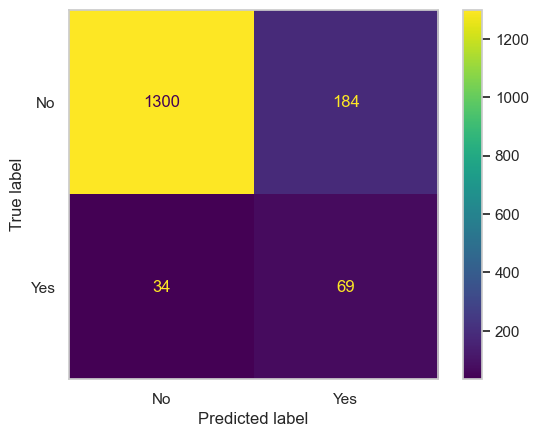

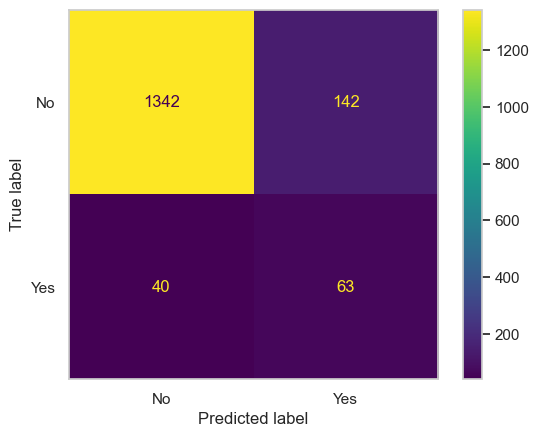

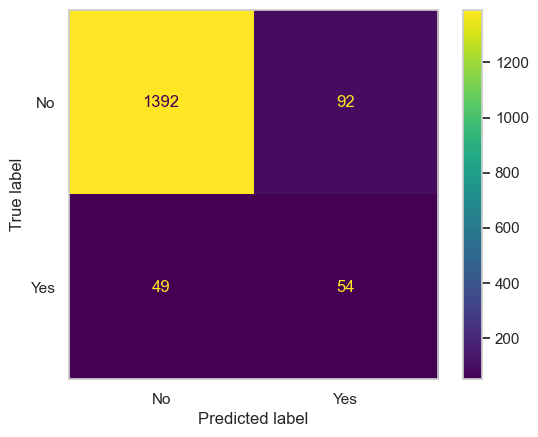

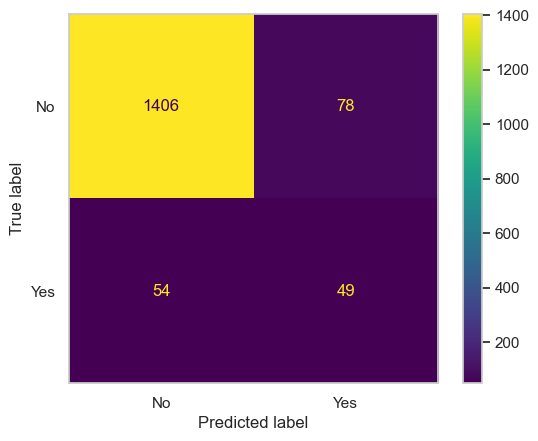

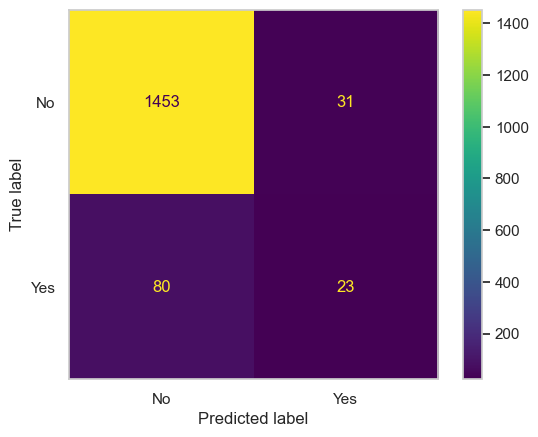

In [35]:
xgb_ratio_2 = xgboost(X_train_ratio_2, y_train_ratio_2)
xgb_ratio_3 = xgboost(X_train_ratio_3, y_train_ratio_3)
xgb_ratio_4 = xgboost(X_train_ratio_4, y_train_ratio_4)
xgb_ratio_5 = xgboost(X_train_ratio_5, y_train_ratio_5)
xgb_ratio_10 = xgboost(X_train_ratio_10, y_train_ratio_10)

ratio_2_xgb = xgb_eval(xgb_ratio_2, X_train_ratio_2, y_train_ratio_2, X_test, y_test)
ratio_3_xgb = xgb_eval(xgb_ratio_3, X_train_ratio_3, y_train_ratio_3, X_test, y_test)
ratio_4_xgb = xgb_eval(xgb_ratio_4, X_train_ratio_4, y_train_ratio_4, X_test, y_test)
ratio_5_xgb = xgb_eval(xgb_ratio_5, X_train_ratio_5, y_train_ratio_5, X_test, y_test)
ratio_10_xgb = xgb_eval(xgb_ratio_10, X_train_ratio_10, y_train_ratio_10, X_test, y_test)

(ratio_2_xgb_report, ratio_2_xgb_accuracy, ratio_2_xgb_precision, ratio_2_xgb_recall, ratio_2_xgb_f1, ratio_2_xgb_roc_auc, ratio_2_xgb_pr_auc, ratio_2_xgb_acc_training) = ratio_2_xgb
(ratio_3_xgb_report, ratio_3_xgb_accuracy, ratio_3_xgb_precision, ratio_3_xgb_recall, ratio_3_xgb_f1, ratio_3_xgb_roc_auc, ratio_3_xgb_pr_auc, ratio_3_xgb_acc_training) = ratio_3_xgb
(ratio_4_xgb_report, ratio_4_xgb_accuracy, ratio_4_xgb_precision, ratio_4_xgb_recall, ratio_4_xgb_f1, ratio_4_xgb_roc_auc, ratio_4_xgb_pr_auc, ratio_4_xgb_acc_training) = ratio_4_xgb
(ratio_5_xgb_report, ratio_5_xgb_accuracy, ratio_5_xgb_precision, ratio_5_xgb_recall, ratio_5_xgb_f1, ratio_5_xgb_roc_auc, ratio_5_xgb_pr_auc, ratio_5_xgb_acc_training) = ratio_5_xgb
(ratio_10_xgb_report, ratio_10_xgb_accuracy, ratio_10_xgb_precision, ratio_10_xgb_recall, ratio_10_xgb_f1, ratio_10_xgb_roc_auc, ratio_10_xgb_pr_auc, ratio_10_xgb_acc_training) = ratio_10_xgb

#### CatBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.6863725	total: 623us	remaining: 92.9ms
1:	learn: 0.6795292	total: 1.41ms	remaining: 104ms
2:	learn: 0.6728975	total: 1.88ms	remaining: 92.1ms
3:	learn: 0.6665118	total: 2.35ms	remaining: 85.7ms
4:	learn: 0.6599210	total: 2.99ms	remaining: 86.6ms
5:	learn: 0.6537292	total: 3.5ms	remaining: 83.9ms
6:	learn: 0.6474147	total: 4.05ms	remaining: 82.8ms
7:	learn: 0.6415153	total: 4.52ms	remaining: 80.3ms
8:	learn: 0.6360096	total: 4.95ms	remaining: 77.6ms
9:	learn: 0.6306060	total: 5.5ms	remaining: 77ms
10:	learn: 0.6253797	total: 5.96ms	remaining: 75.3ms
11:	learn: 0.6205599	total: 6.44ms	remaining: 74.1ms
12:	learn: 0.6155470	total: 6.95ms	remaining: 73.2ms
13:	learn: 0.6108771	total: 7.39ms	remaining: 71.8ms
14:	learn: 0.6058453	total: 7.89ms	remaining: 71ms
15:	learn: 0.6008408	total: 8.35ms	remaining: 70ms
16:	learn: 0.5965262	total: 8.7ms	remaining: 68.1ms
17:	learn: 0.5923756	total: 9.44ms	remaining: 69.2ms
18:	l

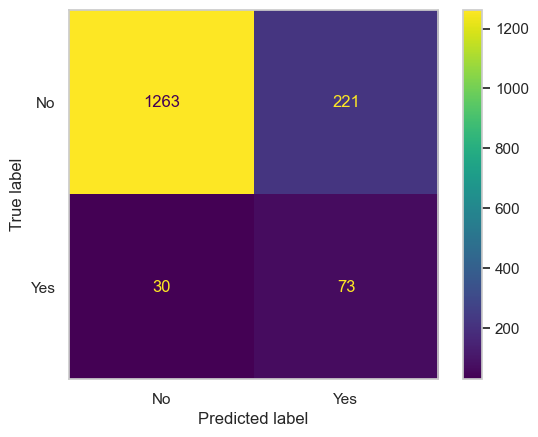

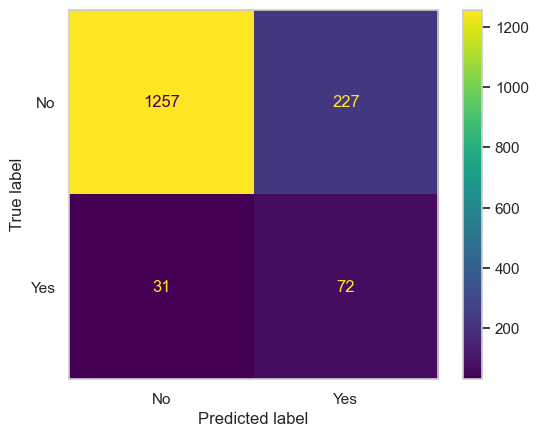

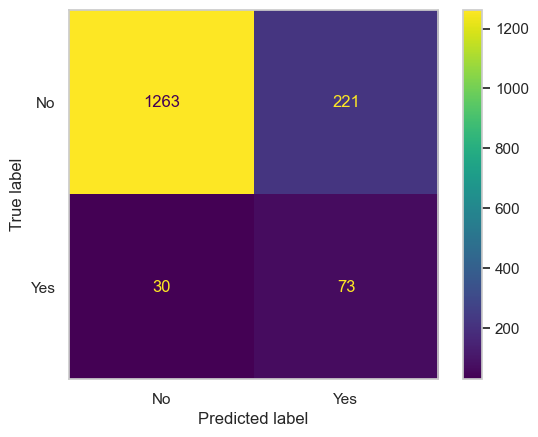

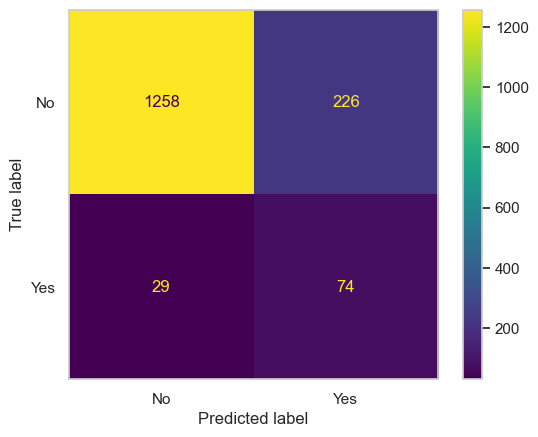

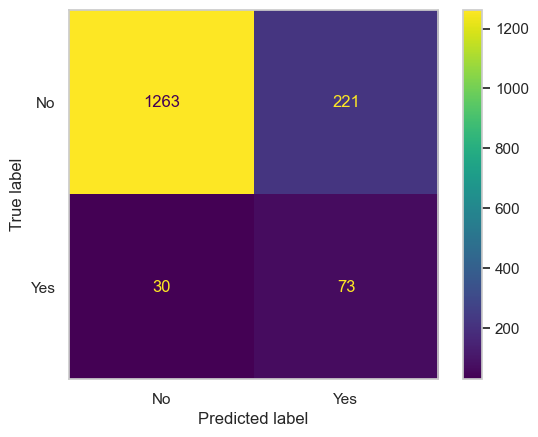

In [36]:
cb_ratio_2 = catboost(X_train_ratio_2, y_train_ratio_2)
cb_ratio_3 = catboost(X_train_ratio_3, y_train_ratio_3)
cb_ratio_4 = catboost(X_train_ratio_4, y_train_ratio_4)
cb_ratio_5 = catboost(X_train_ratio_5, y_train_ratio_5)
cb_ratio_10 = catboost(X_train_ratio_10, y_train_ratio_10)

ratio_2_cb = cb_eval(cb_ratio_2, X_train_ratio_2, y_train_ratio_2, X_test, y_test)
ratio_3_cb = cb_eval(cb_ratio_3, X_train_ratio_3, y_train_ratio_3, X_test, y_test)
ratio_4_cb = cb_eval(cb_ratio_4, X_train_ratio_4, y_train_ratio_4, X_test, y_test)
ratio_5_cb = cb_eval(cb_ratio_5, X_train_ratio_5, y_train_ratio_5, X_test, y_test)
ratio_10_cb = cb_eval(cb_ratio_10, X_train_ratio_10, y_train_ratio_10, X_test, y_test)

(ratio_2_cb_report, ratio_2_cb_accuracy, ratio_2_cb_precision, ratio_2_cb_recall, ratio_2_cb_f1, ratio_2_cb_roc_auc, ratio_2_cb_pr_auc, ratio_2_cb_acc_training) = ratio_2_cb
(ratio_3_cb_report, ratio_3_cb_accuracy, ratio_3_cb_precision, ratio_3_cb_recall, ratio_3_cb_f1, ratio_3_cb_roc_auc, ratio_3_cb_pr_auc, ratio_3_cb_acc_training) = ratio_3_cb
(ratio_4_cb_report, ratio_4_cb_accuracy, ratio_4_cb_precision, ratio_4_cb_recall, ratio_4_cb_f1, ratio_4_cb_roc_auc, ratio_4_cb_pr_auc, ratio_4_cb_acc_training) = ratio_4_cb
(ratio_5_cb_report, ratio_5_cb_accuracy, ratio_5_cb_precision, ratio_5_cb_recall, ratio_5_cb_f1, ratio_5_cb_roc_auc, ratio_5_cb_pr_auc, ratio_5_cb_acc_training) = ratio_5_cb
(ratio_10_cb_report, ratio_10_cb_accuracy, ratio_10_cb_precision, ratio_10_cb_recall, ratio_10_cb_f1, ratio_10_cb_roc_auc, ratio_10_cb_pr_auc, ratio_10_cb_acc_training) = ratio_10_cb

### Visualization

C:\Users\asus\AppData\Local\Temp\ipykernel_27960\76202884.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=f1_df, x="F1-Score", y="Model", hue="Sampling", ci=None, palette="viridis")


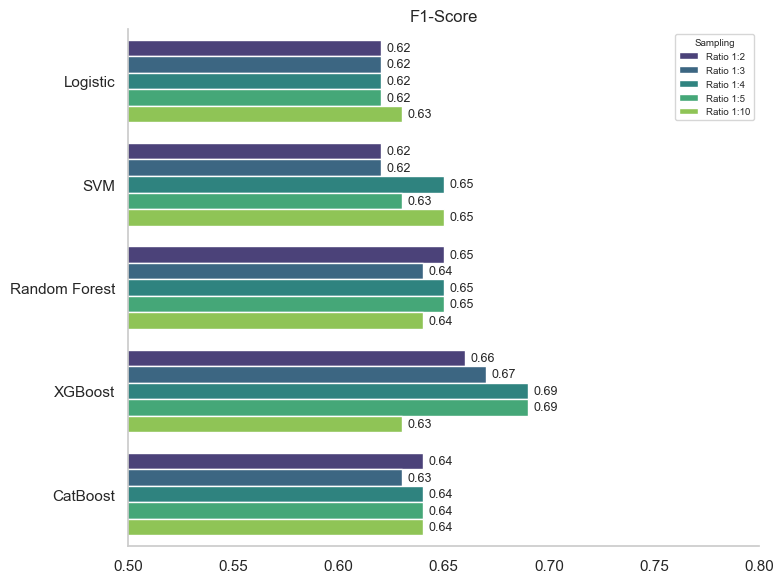

In [37]:
f1 = [
    {"Model": "Logistic", "Sampling": "Ratio 1:2", "F1-Score": float(ratio_2_logistic_f1)},
    {"Model": "Logistic", "Sampling": "Ratio 1:3", "F1-Score": float(ratio_3_logistic_f1)},
    {"Model": "Logistic", "Sampling": "Ratio 1:4", "F1-Score": float(ratio_4_logistic_f1)},
    {"Model": "Logistic", "Sampling": "Ratio 1:5", "F1-Score": float(ratio_5_logistic_f1)},
    {"Model": "Logistic", "Sampling": "Ratio 1:10", "F1-Score": float(ratio_10_logistic_f1)},

    {"Model": "SVM", "Sampling": "Ratio 1:2", "F1-Score": float(ratio_2_svm_f1)},
    {"Model": "SVM", "Sampling": "Ratio 1:3", "F1-Score": float(ratio_3_svm_f1)},
    {"Model": "SVM", "Sampling": "Ratio 1:4", "F1-Score": float(ratio_4_svm_f1)},
    {"Model": "SVM", "Sampling": "Ratio 1:5", "F1-Score": float(ratio_5_svm_f1)},
    {"Model": "SVM", "Sampling": "Ratio 1:10", "F1-Score": float(ratio_10_svm_f1)},

    {"Model": "Random Forest", "Sampling": "Ratio 1:2", "F1-Score": float(ratio_2_rf_f1)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:3", "F1-Score": float(ratio_3_rf_f1)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:4", "F1-Score": float(ratio_4_rf_f1)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:5", "F1-Score": float(ratio_5_rf_f1)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:10", "F1-Score": float(ratio_10_rf_f1)},

    {"Model": "XGBoost", "Sampling": "Ratio 1:2", "F1-Score": float(ratio_2_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:3", "F1-Score": float(ratio_3_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:4", "F1-Score": float(ratio_4_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:5", "F1-Score": float(ratio_5_xgb_f1)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:10", "F1-Score": float(ratio_10_xgb_f1)},

    {"Model": "CatBoost", "Sampling": "Ratio 1:2", "F1-Score": float(ratio_2_cb_f1)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:3", "F1-Score": float(ratio_3_cb_f1)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:4", "F1-Score": float(ratio_4_cb_f1)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:5", "F1-Score": float(ratio_5_cb_f1)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:10", "F1-Score": float(ratio_10_cb_f1)},
]

f1_df = pd.DataFrame.from_records(f1)

model_order = ["Logistic", "SVM", "Random Forest", "XGBoost", "CatBoost"]
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

sampling_order = ["Ratio 1:2", "Ratio 1:3", "Ratio 1:4", "Ratio 1:5", "Ratio 1:10"]
f1_df["Sampling"] = pd.Categorical(f1_df["Sampling"], categories=sampling_order, ordered=True)

f1_df = f1_df.sort_values(["Model", "Sampling"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=f1_df, x="F1-Score", y="Model", hue="Sampling", ci=None, palette="viridis")
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(0.5, 0.8)
plt.title("F1-Score")
plt.legend(title="Sampling", loc="upper right", fontsize=7, title_fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.annotate(f"{width:.2f}", (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=9, xytext=(4, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_27960\1082552607.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=pr_auc_df, x="PR-AUC", y="Model", hue="Sampling", ci=None, palette="viridis")


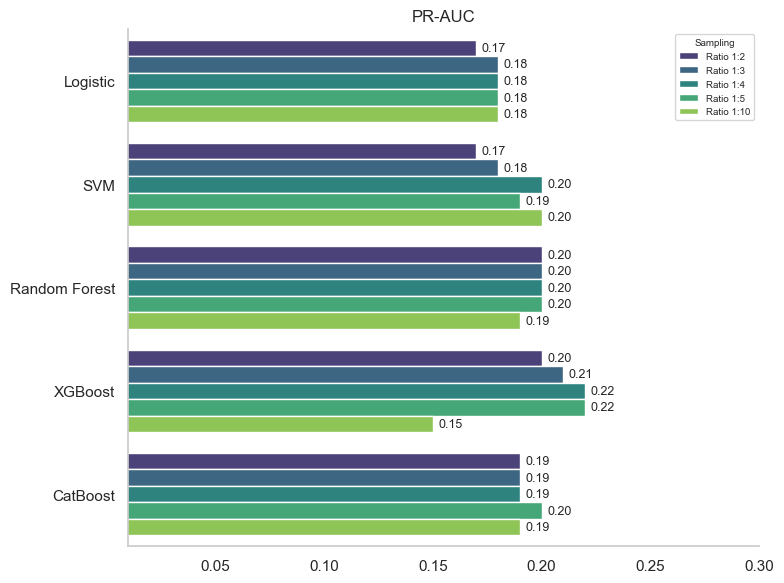

In [38]:
pr_auc = [
    {"Model": "Logistic", "Sampling": "Ratio 1:2", "PR-AUC": float(ratio_2_logistic_pr_auc)},
    {"Model": "Logistic", "Sampling": "Ratio 1:3", "PR-AUC": float(ratio_3_logistic_pr_auc)},
    {"Model": "Logistic", "Sampling": "Ratio 1:4", "PR-AUC": float(ratio_4_logistic_pr_auc)},
    {"Model": "Logistic", "Sampling": "Ratio 1:5", "PR-AUC": float(ratio_5_logistic_pr_auc)},
    {"Model": "Logistic", "Sampling": "Ratio 1:10", "PR-AUC": float(ratio_10_logistic_pr_auc)},

    {"Model": "SVM", "Sampling": "Ratio 1:2", "PR-AUC": float(ratio_2_svm_pr_auc)},
    {"Model": "SVM", "Sampling": "Ratio 1:3", "PR-AUC": float(ratio_3_svm_pr_auc)},
    {"Model": "SVM", "Sampling": "Ratio 1:4", "PR-AUC": float(ratio_4_svm_pr_auc)},
    {"Model": "SVM", "Sampling": "Ratio 1:5", "PR-AUC": float(ratio_5_svm_pr_auc)},
    {"Model": "SVM", "Sampling": "Ratio 1:10", "PR-AUC": float(ratio_10_svm_pr_auc)},

    {"Model": "Random Forest", "Sampling": "Ratio 1:2", "PR-AUC": float(ratio_2_rf_pr_auc)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:3", "PR-AUC": float(ratio_3_rf_pr_auc)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:4", "PR-AUC": float(ratio_4_rf_pr_auc)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:5", "PR-AUC": float(ratio_5_rf_pr_auc)},
    {"Model": "Random Forest", "Sampling": "Ratio 1:10", "PR-AUC": float(ratio_10_rf_pr_auc)},

    {"Model": "XGBoost", "Sampling": "Ratio 1:2", "PR-AUC": float(ratio_2_xgb_pr_auc)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:3", "PR-AUC": float(ratio_3_xgb_pr_auc)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:4", "PR-AUC": float(ratio_4_xgb_pr_auc)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:5", "PR-AUC": float(ratio_5_xgb_pr_auc)},
    {"Model": "XGBoost", "Sampling": "Ratio 1:10", "PR-AUC": float(ratio_10_xgb_pr_auc)},

    {"Model": "CatBoost", "Sampling": "Ratio 1:2", "PR-AUC": float(ratio_2_cb_pr_auc)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:3", "PR-AUC": float(ratio_3_cb_pr_auc)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:4", "PR-AUC": float(ratio_4_cb_pr_auc)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:5", "PR-AUC": float(ratio_5_cb_pr_auc)},
    {"Model": "CatBoost", "Sampling": "Ratio 1:10", "PR-AUC": float(ratio_10_cb_pr_auc)},
]

pr_auc_df = pd.DataFrame.from_records(pr_auc)

model_order = ["Logistic", "SVM", "Random Forest", "XGBoost", "CatBoost"]
pr_auc_df["Model"] = pd.Categorical(pr_auc_df["Model"], categories=model_order, ordered=True)

sampling_order = ["Ratio 1:2", "Ratio 1:3", "Ratio 1:4", "Ratio 1:5", "Ratio 1:10"]
pr_auc_df["Sampling"] = pd.Categorical(pr_auc_df["Sampling"], categories=sampling_order, ordered=True)

pr_auc_df = pr_auc_df.sort_values(["Model", "Sampling"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=pr_auc_df, x="PR-AUC", y="Model", hue="Sampling", ci=None, palette="viridis")
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(0.01, 0.3)
plt.title("PR-AUC")
plt.legend(title="Sampling", loc="upper right", fontsize=7, title_fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

for p in ax.patches:
    width = p.get_width()
    if not np.isnan(width):
        ax.annotate(f"{width:.2f}", (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=9, xytext=(4, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

### Model Comparison

In [40]:
rows = [
    ("Logistic", "Ratio 1:2", ratio_2_logistic_accuracy, ratio_2_logistic_precision, ratio_2_logistic_recall, ratio_2_logistic_f1, ratio_2_logistic_roc_auc, ratio_2_logistic_pr_auc, ratio_2_logistic_acc_training),
    ("Logistic", "Ratio 1:3", ratio_3_logistic_accuracy, ratio_3_logistic_precision, ratio_3_logistic_recall, ratio_3_logistic_f1, ratio_3_logistic_roc_auc, ratio_3_logistic_pr_auc, ratio_3_logistic_acc_training),
    ("Logistic", "Ratio 1:4", ratio_4_logistic_accuracy, ratio_4_logistic_precision, ratio_4_logistic_recall, ratio_4_logistic_f1, ratio_4_logistic_roc_auc, ratio_4_logistic_pr_auc, ratio_4_logistic_acc_training),
    ("Logistic", "Ratio 1:5", ratio_5_logistic_accuracy, ratio_5_logistic_precision, ratio_5_logistic_recall, ratio_5_logistic_f1, ratio_5_logistic_roc_auc, ratio_5_logistic_pr_auc, ratio_5_logistic_acc_training),
    ("Logistic", "Ratio 1:10", ratio_10_logistic_accuracy, ratio_10_logistic_precision, ratio_10_logistic_recall, ratio_10_logistic_f1, ratio_10_logistic_roc_auc, ratio_10_logistic_pr_auc, ratio_10_logistic_acc_training),

    ("SVM", "Ratio 1:2", ratio_2_svm_accuracy, ratio_2_svm_precision, ratio_2_svm_recall, ratio_2_svm_f1, ratio_2_svm_roc_auc, ratio_2_svm_pr_auc, ratio_2_svm_acc_training),
    ("SVM", "Ratio 1:3", ratio_3_svm_accuracy, ratio_3_svm_precision, ratio_3_svm_recall, ratio_3_svm_f1, ratio_3_svm_roc_auc, ratio_3_svm_pr_auc, ratio_3_svm_acc_training),
    ("SVM", "Ratio 1:4", ratio_4_svm_accuracy, ratio_4_svm_precision, ratio_4_svm_recall, ratio_4_svm_f1, ratio_4_svm_roc_auc, ratio_4_svm_pr_auc, ratio_4_svm_acc_training),
    ("SVM", "Ratio 1:5", ratio_5_svm_accuracy, ratio_5_svm_precision, ratio_5_svm_recall, ratio_5_svm_f1, ratio_5_svm_roc_auc, ratio_5_svm_pr_auc, ratio_5_svm_acc_training),
    ("SVM", "Ratio 1:10", ratio_10_svm_accuracy, ratio_10_svm_precision, ratio_10_svm_recall, ratio_10_svm_f1, ratio_10_svm_roc_auc, ratio_10_svm_pr_auc, ratio_10_svm_acc_training),

    ("Random Forest", "Ratio 1:2", ratio_2_rf_accuracy, ratio_2_rf_precision, ratio_2_rf_recall, ratio_2_rf_f1, ratio_2_rf_roc_auc, ratio_2_rf_pr_auc, ratio_2_rf_acc_training),
    ("Random Forest", "Ratio 1:3", ratio_3_rf_accuracy, ratio_3_rf_precision, ratio_3_rf_recall, ratio_3_rf_f1, ratio_3_rf_roc_auc, ratio_3_rf_pr_auc, ratio_3_rf_acc_training),
    ("Random Forest", "Ratio 1:4", ratio_4_rf_accuracy, ratio_4_rf_precision, ratio_4_rf_recall, ratio_4_rf_f1, ratio_4_rf_roc_auc, ratio_4_rf_pr_auc, ratio_4_rf_acc_training),
    ("Random Forest", "Ratio 1:5", ratio_5_rf_accuracy, ratio_5_rf_precision, ratio_5_rf_recall, ratio_5_rf_f1, ratio_5_rf_roc_auc, ratio_5_rf_pr_auc, ratio_5_rf_acc_training),
    ("Random Forest", "Ratio 1:10", ratio_10_rf_accuracy, ratio_10_rf_precision, ratio_10_rf_recall, ratio_10_rf_f1, ratio_10_rf_roc_auc, ratio_10_rf_pr_auc, ratio_10_rf_acc_training),

    ("XGBoost", "Ratio 1:2", ratio_2_xgb_accuracy, ratio_2_xgb_precision, ratio_2_xgb_recall, ratio_2_xgb_f1, ratio_2_xgb_roc_auc, ratio_2_xgb_pr_auc, ratio_2_xgb_acc_training),
    ("XGBoost", "Ratio 1:3", ratio_3_xgb_accuracy, ratio_3_xgb_precision, ratio_3_xgb_recall, ratio_3_xgb_f1, ratio_3_xgb_roc_auc, ratio_3_xgb_pr_auc, ratio_3_xgb_acc_training),
    ("XGBoost", "Ratio 1:4", ratio_4_xgb_accuracy, ratio_4_xgb_precision, ratio_4_xgb_recall, ratio_4_xgb_f1, ratio_4_xgb_roc_auc, ratio_4_xgb_pr_auc, ratio_4_xgb_acc_training),
    ("XGBoost", "Ratio 1:5", ratio_5_xgb_accuracy, ratio_5_xgb_precision, ratio_5_xgb_recall, ratio_5_xgb_f1, ratio_5_xgb_roc_auc, ratio_5_xgb_pr_auc, ratio_5_xgb_acc_training),
    ("XGBoost", "Ratio 1:10", ratio_10_xgb_accuracy, ratio_10_xgb_precision, ratio_10_xgb_recall, ratio_10_xgb_f1, ratio_10_xgb_roc_auc, ratio_10_xgb_pr_auc, ratio_10_xgb_acc_training),

    ("CatBoost", "Ratio 1:2", ratio_2_cb_accuracy, ratio_2_cb_precision, ratio_2_cb_recall, ratio_2_cb_f1, ratio_2_cb_roc_auc, ratio_2_cb_pr_auc, ratio_2_cb_acc_training),
    ("CatBoost", "Ratio 1:3", ratio_3_cb_accuracy, ratio_3_cb_precision, ratio_3_cb_recall, ratio_3_cb_f1, ratio_3_cb_roc_auc, ratio_3_cb_pr_auc, ratio_3_cb_acc_training),
    ("CatBoost", "Ratio 1:4", ratio_4_cb_accuracy, ratio_4_cb_precision, ratio_4_cb_recall, ratio_4_cb_f1, ratio_4_cb_roc_auc, ratio_4_cb_pr_auc, ratio_4_cb_acc_training),
    ("CatBoost", "Ratio 1:5", ratio_5_cb_accuracy, ratio_5_cb_precision, ratio_5_cb_recall, ratio_5_cb_f1, ratio_5_cb_roc_auc, ratio_5_cb_pr_auc, ratio_5_cb_acc_training),
    ("CatBoost", "Ratio 1:10", ratio_10_cb_accuracy, ratio_10_cb_precision, ratio_10_cb_recall, ratio_10_cb_f1, ratio_10_cb_roc_auc, ratio_10_cb_pr_auc, ratio_10_cb_acc_training),
]
results = {}
for model_name, sampling, acc, precision, recall, f1, roc_auc, pr_auc, acc_training in rows:
    results.setdefault(sampling, {})[model_name] = {
        "accuracy": float(acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1-score": float(f1),
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        "acc_training": (acc_training)
    }
df_results = pd.DataFrame(rows, columns=["Model", "Sampling", "Accuracy", "Precision", "Recall", "F1-score", "ROC_AUC", "PR_AUC", "Acc_Training"])

df_results["Model"] = pd.Categorical(df_results["Model"], categories=model_order, ordered=True)
sampling_order_full = ["Ratio 1:2", "Ratio 1:3", "Ratio 1:4", "Ratio 1:5", "Ratio 1:10"]
df_results["Sampling"] = pd.Categorical(df_results["Sampling"], categories=sampling_order_full, ordered=True)

df_results = df_results.sort_values(["Sampling", "Model"]).reset_index(drop=True)

metric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC_AUC", "PR_AUC", "Acc_Training"]
df_results[metric_cols] = df_results[metric_cols]

df_results

,Model,Sampling,Accuracy,Precision,Recall,F1-score,ROC_AUC,PR_AUC,Acc_Training
0,Logistic,Ratio 1:2,0.825457,0.60,0.76,0.62,0.76,0.17,0.80 ± 0.02
1,SVM,Ratio 1:2,0.829868,0.60,0.75,0.62,0.75,0.17,0.81 ± 0.03
2,Random Forest,Ratio 1:2,0.851292,0.62,0.78,0.65,0.78,0.20,0.81 ± 0.02
3,XGBoost,Ratio 1:2,0.862634,0.62,0.77,0.66,0.77,0.20,0.81 ± 0.03
4,CatBoost,Ratio 1:2,0.841840,0.61,0.78,0.64,0.78,0.19,0.81 ± 0.03
5,Logistic,Ratio 1:3,0.833018,0.60,0.76,0.62,0.76,0.18,0.80 ± 0.01
6,SVM,Ratio 1:3,0.828607,0.60,0.77,0.62,0.77,0.18,0.80 ± 0.02
7,Random Forest,Ratio 1:3,0.848771,0.62,0.77,0.64,0.77,0.20,0.81 ± 0.01
8,XGBoost,Ratio 1:3,0.885318,0.64,0.76,0.67,0.76,0.21,0.78 ± 0.02
9,CatBoost,Ratio 1:3,0.837429,0.61,0.77,0.63,0.77,0.19,0.82 ± 0.01
